# TOU 전국보급시 전력사용량 예측
(목표) 한국전력공사에서 시범 운영중인 TOU 전력가격정책이 전국확대시 어떻게 달라질지 예측해 봄 

(배경) 2020년~2022년 제주도에서 시범운영된 TOU 정책에 따라, 전력 사용량이 어떻게 변화 했는지 탐색하고 전국확대 보급시 전력 사용량 변화를 예측해봄

(방법) 시계열 분석을 통해 전력사용량 데이터의 EDA를 수행하고,ARIMA 모델을 모델링하여 2023년 전력사용량을 예측하고 전국 확대시 유의적인 변화가 발생할지 알아봄.

# 1. 데이터 수집 및 EDA

In [1]:
# 필요한 라이브러리를 로딩한다.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# 화면에 경고 메시지를 띄우지 않는다.
import warnings
warnings.filterwarnings('ignore') 
import datetime as dt
import os
from glob import glob

# 한글폰트를 설정한다.
plt.rc("font", family="Malgun Gothic")# 윈도우
#plt.rc("font", family="Apple Gothic") #Mac

# 특수기호에 대한 설정을 한다.
plt.rc("axes", unicode_minus=False)

from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA

# import pmdarima as pm
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
from plotly.offline import iplot, init_notebook_mode
from scipy.optimize import minimize
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
from scipy.stats import mannwhitneyu

## 1.1 데이터 수집

In [2]:
# Dayofweek 함수생성
def Dayofweek(dataset, feature):
  dataset['day_of_week'] = dataset[feature].dt.dayofweek
  dataset['notes'] = dataset['day_of_week'].map({0: 'Weekday', 1: 'Weekday', 2: 'Weekday', 3: 'Weekday', 4: 'Weekday', 5: 'Weekend', 6: 'Weekend'})
  dataset['day_of_week'] = dataset['day_of_week'].map({0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'})
  return dataset

### 1.1.1 제주도 TOU 
데이터 수집

In [3]:
path = 'C:/Users/bigdata08/Cisters/final/Rawdata/Rawdata_tou'
file = '/*.csv'

In [4]:
tou_path = glob(path + file)
len(tou_path)

3

In [5]:
tou_df = pd.DataFrame()

for path in tou_path :
    single = pd.read_csv(path)
    tou_df = pd.concat([tou_df, single])
    print(tou_df.shape)
    
    del single

(405821, 28)
(848258, 28)
(1325673, 28)


In [8]:
tou_df['년도'].unique() # 2020~2022년 시범운영된 상황으로 2020~2022년에 대한 분석을 수행함

array([2020, 2021, 2022], dtype=int64)

In [10]:
tou_df.to_csv('./rawdata/all_tou_data.csv', index = False)

PIVOT melting

In [11]:
tou = pd.read_csv('./rawdata/all_tou_data.csv')

In [ ]:
weather = pd.read_csv('./rawdata/all_weather_2020_2022.csv')
weather.head()

In [14]:
tou['시도'] = '제주본부'

In [15]:
tou.rename(columns = {'시도' : 'city', '대체고객번호' : 'user','년도' : 'year', '월' : 'month', '일' : 'day'}, inplace = True)
weather.rename(columns = {'일시' : 'date', '기온' : 'temp', '강수량' : 'rain', '본부명' : 'city'}, inplace = True)
weather = weather[['date', 'temp', 'city']]
weather['date'] = pd.to_datetime(weather['date'])

In [ ]:
#### tou melting

tou_melt = pd.melt(tou, id_vars=['city', 'user', 'year', 'month', 'day'], 
                   value_vars=['1h', '2h', '3h', '4h', '5h', '6h', '7h', '8h', '9h', '10h', 
                               '11h', '12h', '13h', '14h', '15h', '16h', '17h', '18h', '19h', 
                               '20h', '21h', '22h', '23h', '24h'], 
                   var_name='hour', value_name='power')

# '년도', '월', '일', '시'를 조합하여 '날짜'라는 새로운 열을 생성합니다
tou_melt['hour'] = tou_melt['hour'].apply(lambda x : x.replace('h', ''))
tou_melt['date'] = pd.to_datetime(tou_melt[['year', 'month', 'day', 'hour']])

# 결과를 확인합니다
print(tou_melt.head())

In [ ]:
tou_melted = pd.merge(tou_melt, weather, how = 'left', on = ('date', 'city'))
tou_melted.head()

#### 일자 및 주말 컬럼 만들기

In [ ]:
Dayofweek(tou_melted, 'date')

In [19]:
#year_month 컬럼 만들기

tou_melted['year_month'] = tou_melted['year'].astype('str') + '-' + tou_melted['month'].astype('str')

In [ ]:
tou_melted['date'].sort_values()

In [21]:
tou_melted = tou_melted.loc[tou_melted['temp'].isna() == False] # temp에는 없는 2023-01-01데이터 제거

In [22]:
tou_melted.to_csv('./sample/melted_tou.csv', index = False)

### 1.1.2 전국 시도별 고압

In [23]:
path = 'C:/Users/bigdata08/Cisters/final/Rawdata/Rawdata_high'
file = '/*.csv'

In [24]:
high_path = glob(path + file)
len(high_path)

19

In [25]:
high_df = pd.DataFrame()

for path in high_path :
    single = pd.read_csv(path)
    high_df = pd.concat([high_df, single])
    print(high_df.shape)
    
    del single

(387803, 29)
(808377, 29)
(1112100, 29)
(1515128, 29)
(1883846, 29)
(2259916, 29)
(2621206, 29)
(3076463, 29)
(3522131, 29)
(3915685, 29)
(4288048, 29)
(4737394, 29)
(5085530, 29)
(5416319, 29)
(5815757, 29)
(6251023, 29)
(6688581, 29)
(7111531, 29)
(7514825, 29)


In [26]:
# tou에 맞춰 전국 고압 또한 2020~2022년 데이터 사용

high = high_df.loc[(high_df['년도'] < 2023) & (high_df['년도'] > 2019)]

In [ ]:
high.to_csv('./rawdata/all_high_data_20-22.csv', index = False)

PIVOT melting

In [8]:
high = pd.read_csv('./rawdata/all_high_data_20-22.csv')
weather = pd.read_csv('./rawdata/all_weather_2020_2022.csv')

In [9]:
high.rename(columns = {'시도' : 'city', '대체고객번호' : 'user','년도' : 'year', '월' : 'month', '일' : 'day'}, inplace = True)
weather.rename(columns = {'일시' : 'date', '기온' : 'temp', '강수량' : 'rain', '본부명' : 'city'}, inplace = True)
weather = weather[['date', 'temp', 'city']]
weather['date'] = pd.to_datetime(weather['date'])

In [10]:
# 년당 300일 이상의 데이터가 있는 고객만 모으기 + 2020~2022년 데이터

high['cnt'] = 1
high_df = high.groupby(['city', 'year', 'user']).agg({'cnt' : np.sum}).reset_index()
high_df = high_df.loc[high_df['cnt'] > 300 ]

In [11]:
# 고객별 명수 확인 - 강원본부 : 155명으로 가장 낮았음

high_df[['city', 'year']].value_counts().reset_index().sort_values(by = 0).head(5)

,city,year,0
56,강원본부,2020,155
55,광주,2020,156
54,울산,2020,183
53,경기북부본부,2020,184
52,경북본부,2020,191


In [ ]:
high_cus = high_df[['city', 'year', 'user']].drop_duplicates()
high_sample = high_cus.groupby(['city', 'year']).sample(n=45, random_state=57)
high_sampling = pd.merge(high_sample, high, how = 'left', on = ('city', 'year', 'user'))
high_sampling.head()

In [ ]:
#### 고압 melting

high_melt = pd.melt(high_sampling, id_vars=['city', 'user', 'year', 'month', 'day'], 
                   value_vars=['0100', '0200', '0300', '0400', '0500', '0600', '0700', '0800', '0900', '1000', '1100', '1200',
             '1300', '1400', '1500', '1600', '1700', '1800', '1900', '2000', '2100', '2200', '2300', '2400'], 
                   var_name='hour', value_name='power')

# '년도', '월', '일', '시'를 조합하여 '날짜'라는 새로운 열을 생성합니다
high_melt['hour'] = high_melt['hour'].apply(lambda x : x.replace('00', ''))
high_melt['date'] = pd.to_datetime(high_melt[['year', 'month', 'day', 'hour']])

# 결과를 확인합니다
print(high_melt.head())

In [15]:
high_melted = pd.merge(high_melt, weather, how = 'left', on = ('date', 'city'))

일자 및 주말 컬럼 만들기

In [ ]:
Dayofweek(high_melted, 'date')

In [ ]:
# year_month 컬럼
high_melted['year_month'] = high_melted['year'].astype('str') + '-' + high_melted['month'].astype('str')
high_melted.head()

In [18]:
high_melted['date'].sort_values() # temp에는 없는 2023 데이터 제거

0          2020-01-01 01:00:00
788514     2020-01-01 01:00:00
151398     2020-01-01 01:00:00
52314      2020-01-01 01:00:00
788149     2020-01-01 01:00:00
                   ...        
21691715   2023-01-01 00:00:00
21692080   2023-01-01 00:00:00
21692445   2023-01-01 00:00:00
21683685   2023-01-01 00:00:00
22331279   2023-01-01 00:00:00
Name: date, Length: 22331280, dtype: datetime64[ns]

In [19]:
high_melted = high_melted.loc[high_melted['temp'].isna() == False]

In [20]:
high_melted.to_csv('./sample/melted_high.csv', index = False)

### 1.1.3 전국 시도별 저압

In [29]:
path = 'C:/Users/bigdata08/Cisters/final/Rawdata/Rawdata_low'
file = '/*.csv'

In [30]:
low_path = glob(path + file)
len(low_path)

19

In [31]:
low_df = pd.DataFrame()

for path in low_path :
    single = pd.read_csv(path)
    low_df = pd.concat([low_df, single])
    print(low_df.shape)
    
    del single

(254160, 29)
(590294, 29)
(930736, 29)
(1194755, 29)
(1578788, 29)
(1831132, 29)
(2129372, 29)
(2354198, 29)
(2641496, 29)
(3005777, 29)
(3316866, 29)
(3678177, 29)
(4031836, 29)
(4307268, 29)
(4632752, 29)
(4941830, 29)
(5320503, 29)
(5650470, 29)
(5834308, 29)


In [32]:
# tou에 맞춰 전국 고압 또한 2020~2022년 데이터 사용

low = low_df.loc[(low_df['년도'] < 2023) & (low_df['년도'] > 2019)]

In [ ]:
low.to_csv('./rawdata/all_low_data_20-22.csv', index = False)

Pivoting

In [34]:
low = pd.read_csv('./rawdata/all_low_data_20-22.csv')
weather = pd.read_csv('./rawdata/all_weather_2020_2022.csv')

In [35]:
low.rename(columns = {'시도' : 'city', '대체고객번호' : 'user','년도' : 'year', '월' : 'month', '일' : 'day'}, inplace = True)
weather.rename(columns = {'일시' : 'date', '기온' : 'temp', '강수량' : 'rain', '본부명' : 'city'}, inplace = True)
weather = weather[['date', 'temp', 'city']]
weather['date'] = pd.to_datetime(weather['date'])

In [36]:
# 년당 300일 이상의 데이터가 있는 고객만 모으기 + 2020~2022년 데이터

low['cnt'] = 1
low_df = low.groupby(['city', 'year', 'user']).agg({'cnt' : np.sum}).reset_index()
low_df = low_df.loc[low_df['cnt'] > 300 ]

In [37]:
# 고객별 명수 확인 - 충북본부 : 47명으로 가장 낮았음

low_df[['city', 'year']].value_counts().reset_index().sort_values(by = 0).head(5)

,city,year,0
56,충북본부,2020,47
55,충북본부,2021,99
54,인천본부,2020,103
53,광주,2020,105
52,경남본부,2020,112


In [38]:
low_cus = low_df[['city', 'year', 'user']].drop_duplicates()
low_sample = low_cus.groupby(['city', 'year']).sample(n=45, random_state=57)
low_sampling = pd.merge(low_sample, low, how = 'left', on = ('city', 'year', 'user'))

In [ ]:
low_sampling.head()

In [ ]:
#### 저압 melting

low_melt = pd.melt(low_sampling, id_vars=['city', 'user', 'year', 'month', 'day'], 
                   value_vars=['0100', '0200', '0300', '0400', '0500', '0600', '0700', '0800', '0900', '1000', '1100', '1200',
             '1300', '1400', '1500', '1600', '1700', '1800', '1900', '2000', '2100', '2200', '2300', '2400'], 
                   var_name='hour', value_name='power')

# '년도', '월', '일', '시'를 조합하여 '날짜'라는 새로운 열을 생성합니다
low_melt['hour'] = low_melt['hour'].apply(lambda x : x.replace('00', ''))
low_melt['date'] = pd.to_datetime(low_melt[['year', 'month', 'day', 'hour']])

# 결과를 확인합니다
print(low_melt.head())

In [41]:
low_melted = pd.merge(low_melt, weather, how = 'left', on = ('date', 'city'))

일자 및 주말 칼럼 만들기

In [ ]:
Dayofweek(low_melted, 'date')

In [ ]:
# year_month 컬럼
low_melted['year_month'] = low_melted['year'].astype('str') + '-' + low_melted['month'].astype('str')
low_melted.head()

In [44]:
low_melted['date'].sort_values() # temp 에는 없는 2023년 데이터 제거

0          2020-01-01 01:00:00
877104     2020-01-01 01:00:00
340585     2020-01-01 01:00:00
877456     2020-01-01 01:00:00
877812     2020-01-01 01:00:00
                   ...        
21431953   2023-01-01 00:00:00
21432318   2023-01-01 00:00:00
21432681   2023-01-01 00:00:00
21433411   2023-01-01 00:00:00
22064447   2023-01-01 00:00:00
Name: date, Length: 22064448, dtype: datetime64[ns]

In [45]:
low_melted = low_melted.loc[low_melted['temp'].isna() == False]

In [49]:
low_melted.to_csv('./sample/melted_low.csv', index = False)

## 1.2 데이터 결측치 처리

In [50]:
low_melted = pd.read_csv('./sample/melted_low.csv')
high_melted = pd.read_csv('./sample/melted_high.csv')
tou_melted = pd.read_csv('./sample/melted_tou.csv')

### 대치법 사용

In [51]:
from scipy import interpolate

low_melted['power'] =low_melted.power.fillna(method = 'ffill')
high_melted['power'] =high_melted.power.fillna(method = 'ffill')
tou_melted['power'] =tou_melted.power.fillna(method = 'ffill')

In [52]:
low_melted.isna().sum()

city           0
user           0
year           0
month          0
day            0
hour           0
power          0
date           0
temp           0
day_of_week    0
notes          0
year_month     0
dtype: int64

In [53]:
high_melted.isna().sum()

city           0
user           0
year           0
month          0
day            0
hour           0
power          0
date           0
temp           0
day_of_week    0
notes          0
year_month     0
dtype: int64

In [54]:
tou_melted.isna().sum()

city           0
user           0
year           0
month          0
day            0
hour           0
power          0
date           0
temp           0
day_of_week    0
notes          0
year_month     0
dtype: int64

In [56]:
low_melted.columns

Index(['city', 'user', 'year', 'month', 'day', 'hour', 'power', 'date', 'temp',
       'day_of_week', 'notes', 'year_month'],
      dtype='object')

In [57]:
high_melted.columns

Index(['city', 'user', 'year', 'month', 'day', 'hour', 'power', 'date', 'temp',
       'day_of_week', 'notes', 'year_month'],
      dtype='object')

In [58]:
tou_melted.columns

Index(['city', 'user', 'year', 'month', 'day', 'hour', 'power', 'date', 'temp',
       'day_of_week', 'notes', 'year_month'],
      dtype='object')

## 1.3 데이터 이상치 EDA 및 처리

### 1.3.1 데이터 이상치 EDA 

시간대별 이상치 기준을 나누어 이상치 기준 잡기 

In [39]:
low_pivot= pd.pivot_table(low_melted, values='power', index = ['city', 'year', 'user', 'month', 'day', 'temp'], columns='hour')
high_pivot =pd.pivot_table(high_melted, values='power', index = ['city', 'year', 'user', 'month', 'day', 'temp'], columns='hour')
tou_pivot= pd.pivot_table(tou_melted, values='power', index = ['city', 'year', 'user', 'month', 'day', 'temp'], columns='hour')

low_df = low_pivot.reset_index()
high_df = high_pivot.reset_index()
tou_df = tou_pivot.reset_index()

In [40]:
low_df.columns

Index([ 'city',  'year',  'user', 'month',   'day',  'temp',       1,       2,
             3,       4,       5,       6,       7,       8,       9,      10,
            11,      12,      13,      14,      15,      16,      17,      18,
            19,      20,      21,      22,      23,      24],
      dtype='object', name='hour')

In [41]:
low_df.rename(columns = {1: '1',2: '2',3: '3',4: '4',5: '5',6: '6',7: '7',
8: '8',9: '9',10: '10',11: '11',12: '12',13: '13',14: '14',15: '15',16: '16',
17: '17',18: '18',19: '19',20: '20',21: '21',22: '22',23: '23',24: '24'}, inplace = True)

high_df.rename(columns = {1: '1',2: '2',3: '3',4: '4',5: '5',6: '6',7: '7',
8: '8',9: '9',10: '10',11: '11',12: '12',13: '13',14: '14',15: '15',16: '16',
17: '17',18: '18',19: '19',20: '20',21: '21',22: '22',23: '23',24: '24'}, inplace = True)

tou_df.rename(columns = {1: '1',2: '2',3: '3',4: '4',5: '5',6: '6',7: '7',
8: '8',9: '9',10: '10',11: '11',12: '12',13: '13',14: '14',15: '15',16: '16',
17: '17',18: '18',19: '19',20: '20',21: '21',22: '22',23: '23',24: '24'}, inplace = True)

In [43]:
low_df = low_df.groupby(['city', 'year', 'month', 'day', 'user'])['1', '2', '3', '4', '5',
       '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17',
       '18', '19', '20', '21', '22', '23', '24'].mean().reset_index()
high_df = high_df.groupby(['city', 'year', 'month', 'day', 'user'])['1', '2', '3', '4', '5',
       '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17',
       '18', '19', '20', '21', '22', '23', '24'].mean().reset_index()
tou_df = tou_df.groupby(['city', 'year', 'month', 'day', 'user'])['1', '2', '3', '4', '5',
       '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17',
       '18', '19', '20', '21', '22', '23', '24'].mean().reset_index()

이상치 내부 및 외부 구분하는 함수

In [44]:
#이상치 내부

def outlier_inner(all_df, col, other_col):
    iqr_df = pd.DataFrame(columns = ['Q1', 'Q3', 'IQR', 'lower_bound', 'upper_bound'])
    desc_df = all_df.describe().T

    iqr_df['Q1'] = desc_df['25%'][col]
    iqr_df['Q3'] = desc_df['75%'][col]
    iqr_df['IQR'] = iqr_df['Q3'] - iqr_df['Q1']
    iqr_df['lower_bound'] = (iqr_df['Q1'] - 1.5 * iqr_df['IQR'])
    iqr_df['upper_bound'] = (iqr_df['Q3'] + 1.5 * iqr_df['IQR'])
    iqr_df_T = iqr_df.T
    gt_df = all_df[col][(all_df.gt(iqr_df_T.loc['upper_bound']) == False)]
    return pd.concat([all_df[other_col], gt_df], axis = 1) 


#이상치 외부

def outlier_outer(all_df, col, other_col):
    iqr_df = pd.DataFrame(columns = ['Q1', 'Q3', 'IQR', 'lower_bound', 'upper_bound'])
    desc_df = all_df.describe().T

    iqr_df['Q1'] = desc_df['25%'][col]
    iqr_df['Q3'] = desc_df['75%'][col]
    iqr_df['IQR'] = iqr_df['Q3'] - iqr_df['Q1']
    iqr_df['lower_bound'] = (iqr_df['Q1'] - 1.5 * iqr_df['IQR'])
    iqr_df['upper_bound'] = (iqr_df['Q3'] + 1.5 * iqr_df['IQR'])
    iqr_df_T = iqr_df.T
    gt_df = all_df[col][(all_df.gt(iqr_df_T.loc['upper_bound']))]
    return pd.concat([all_df[other_col], gt_df], axis = 1) 

In [45]:
# 각 전국 고압, 저압 및 TOU 별로 이상치 내부, 외부 나누기

# low
low_df_inner = outlier_inner(low_df, [ '1', '2', '3', '4', '5',
       '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17',
       '18', '19', '20', '21', '22', '23', '24'], 
              ['city', 'year', 'month', 'day', 'user'])

low_df_outer = outlier_outer(low_df, [ '1', '2', '3', '4', '5',
       '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17',
       '18', '19', '20', '21', '22', '23', '24'], 
              ['city', 'year', 'month', 'day', 'user'])

#high
high_df_inner = outlier_inner(high_df, [ '1', '2', '3', '4', '5',
       '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17',
       '18', '19', '20', '21', '22', '23', '24'],          
              ['city', 'year', 'month', 'day', 'user'])

high_df_outer = outlier_outer(high_df, [ '1', '2', '3', '4', '5',
       '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17',
       '18', '19', '20', '21', '22', '23', '24'], 
              ['city', 'year', 'month', 'day', 'user'])

# tou
tou_df_inner = outlier_inner(tou_df, [ '1', '2', '3', '4', '5',
       '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17',
       '18', '19', '20', '21', '22', '23', '24'], 
              ['city', 'year', 'month', 'day', 'user'])

tou_df_outer = outlier_outer(tou_df, [ '1', '2', '3', '4', '5',
       '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17',
       '18', '19', '20', '21', '22', '23', '24'], 
              ['city', 'year', 'month', 'day', 'user'])

In [ ]:
# 재 melting 하여 구성

# 저압 이상치 내부 melt
low_inner_melt = pd.melt(low_df_inner, id_vars=['user', 'year', 'month', 'day'], 
                   value_vars=['1', '2', '3', '4', '5',
       '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17',
       '18', '19', '20', '21', '22', '23', '24'], 
                   var_name='hour', value_name='power')

# 년 월 일 --> 날짜 타입 데이터
low_inner_melt['date'] = pd.to_datetime(low_inner_melt[['year', 'month', 'day', 'hour']])

print(low_inner_melt.head())


# 저압 이상치 외부 melt

low_outer_melt = pd.melt(low_df_outer, id_vars=['user', 'year', 'month', 'day'], 
                   value_vars=['1', '2', '3', '4', '5',
       '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17',
       '18', '19', '20', '21', '22', '23', '24'], 
                   var_name='hour', value_name='power')

# 년 월 일 --> 날짜 타입 데이터
low_outer_melt['date'] = pd.to_datetime(low_outer_melt[['year', 'month', 'day', 'hour']])

print(low_outer_melt.head())

In [ ]:
# 고압 이상치 내부 melt
high_inner_melt = pd.melt(high_df_inner, id_vars=['user', 'year', 'month', 'day'], 
                   value_vars=['1', '2', '3', '4', '5',
       '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17',
       '18', '19', '20', '21', '22', '23', '24'], 
                   var_name='hour', value_name='power')

# 년 월 일 --> 날짜 타입 데이터
high_inner_melt['date'] = pd.to_datetime(high_inner_melt[['year', 'month', 'day', 'hour']])

print(low_inner_melt.head())



# 고압 이상치 외부 melt

high_outer_melt = pd.melt(high_df_outer, id_vars=['user', 'year', 'month', 'day'], 
                   value_vars=['1', '2', '3', '4', '5',
       '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17',
       '18', '19', '20', '21', '22', '23', '24'], 
                   var_name='hour', value_name='power')

# 년 월 일 --> 날짜 타입 데이터
high_outer_melt['date'] = pd.to_datetime(high_outer_melt[['year', 'month', 'day', 'hour']])

print(high_outer_melt.head())

In [ ]:
# TOU 이상치 내부 melt
tou_inner_melt = pd.melt(tou_df_inner, id_vars=['user', 'year', 'month', 'day'], 
                   value_vars=['1', '2', '3', '4', '5',
       '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17',
       '18', '19', '20', '21', '22', '23', '24'], 
                   var_name='hour', value_name='power')

# 년 월 일 --> 날짜 타입 데이터
tou_inner_melt['date'] = pd.to_datetime(tou_inner_melt[['year', 'month', 'day', 'hour']])

print(tou_inner_melt.head())



# TOU 이상치 외부 melt
tou_outer_melt = pd.melt(tou_df_outer, id_vars=['user', 'year', 'month', 'day'], 
                   value_vars=['1', '2', '3', '4', '5',
       '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17',
       '18', '19', '20', '21', '22', '23', '24'], 
                   var_name='hour', value_name='power')

# 년 월 일 --> 날짜 타입 데이터
tou_outer_melt['date'] = pd.to_datetime(tou_outer_melt[['year', 'month', 'day', 'hour']])

print(tou_outer_melt.head())

In [49]:
print(len(low_inner_melt),len(low_outer_melt),len(high_inner_melt),len(high_outer_melt),len(tou_inner_melt), len(tou_outer_melt))

19722576 19722576 19975944 19975944 31726152 31726152


### 1.3.2 이상치 히스토그램

(0.0, 300.0)

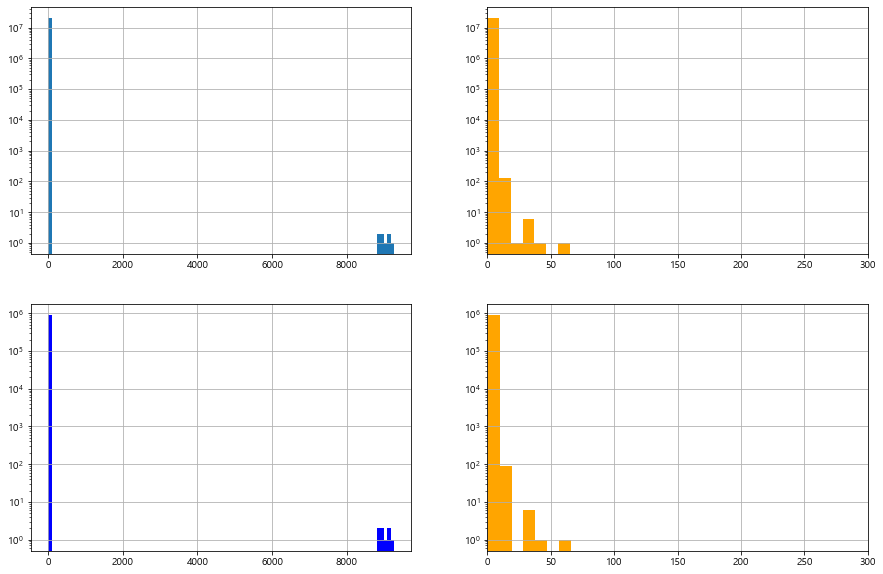

In [52]:
# 저압 이상치 히스토그램
plt.figure(figsize = (15, 10))

# 기존 히스토그램
plt.subplot(2, 2, 1)
low_melted['power'].hist(bins = 100, log = True)

plt.subplot(2, 2, 2)
low_melted['power'].hist(bins = 1000, log = True, color = 'orange').set_xlim(0, 300)

# 이상치 외부 히스토그램
plt.subplot(2, 2, 3)
low_outer_melt['power'].hist(bins = 100, log = True, color = 'blue')

plt.subplot(2, 2, 4)
low_outer_melt['power'].hist(bins = 1000, log = True, color = 'orange').set_xlim(0, 300)
#기준 100 이상의 데이터는 걷어내기

(0.0, 30.0)

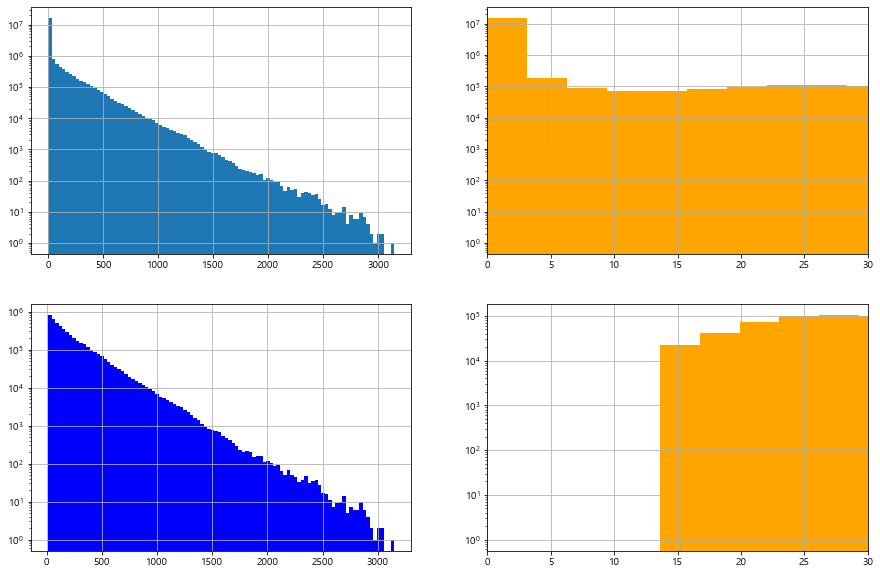

In [53]:
# 고압 이상치 히스토그램
plt.figure(figsize = (15, 10))

# 기존 히스토그램
plt.subplot(2, 2, 1)
high_melted['power'].hist(bins = 100, log = True)

plt.subplot(2, 2, 2)
high_melted['power'].hist(bins = 1000, log = True, color = 'orange').set_xlim(0, 30)

# 이상치 외부 히스토그램
plt.subplot(2, 2, 3)
high_outer_melt['power'].hist(bins = 100, log = True, color = 'blue')

plt.subplot(2, 2, 4)
high_outer_melt['power'].hist(bins = 1000, log = True, color = 'orange').set_xlim(0, 30)


####고압 = power10 이상의 데이터는 걷어내기

(0.0, 1000.0)

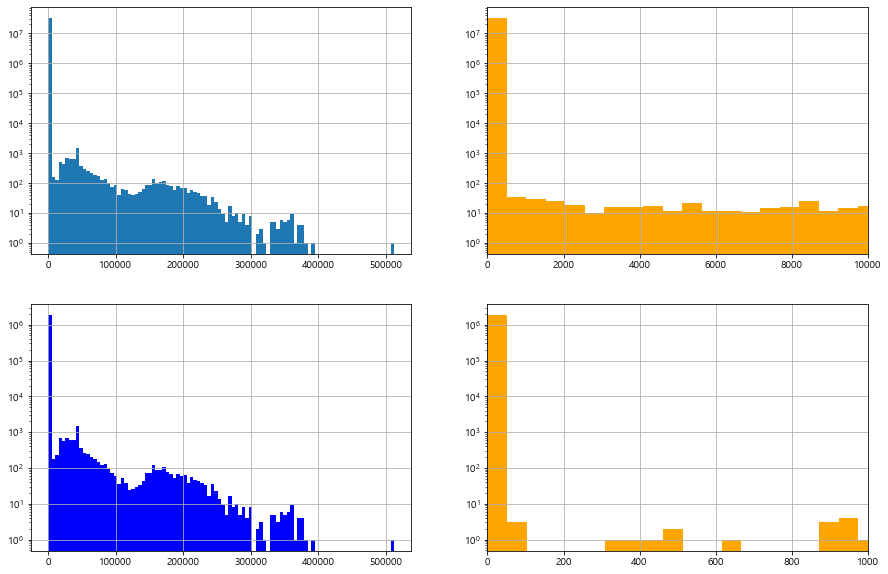

In [256]:
# TOU 이상치 히스토그램
plt.figure(figsize = (15, 10))

# 기존 히스토그램
plt.subplot(2, 2, 1)
tou_melted['power'].hist(bins = 100, log = True)

plt.subplot(2, 2, 2)
tou_melted['power'].hist(bins = 1000, log = True, color = 'orange').set_xlim(0, 10000)

# 이상치 외부 히스토그램
plt.subplot(2, 2, 3)
tou_outer_melt['power'].hist(bins = 100, log = True, color = 'blue')

plt.subplot(2, 2, 4)
tou_outer_melt['power'].hist(bins = 10000, log = True, color = 'orange').set_xlim(0, 1000)
#기준 100 이상의 데이터는 걷어내기

### 1.3.3 이상치 처리

> 이상치 기준
> - 저압/tou : 100이상 커트
> - 고압 : 10 이하 커트

In [61]:
low_df = low_melted.loc[low_melted['power'] <= 100]
high_df = high_melted.loc[high_melted['power'] >= 10]
tou_df = tou_melted.loc[tou_melted['power'] <= 100]

In [62]:
low_df['date'] = pd.to_datetime(low_df['date'])
high_df['date'] = pd.to_datetime(high_df['date'])
tou_df['date'] = pd.to_datetime(tou_df['date'])

In [ ]:
low_df.to_csv('./sample/sampled_low.csv', index = False)
high_df.to_csv('./sample/sampled_high.csv', index = False)
tou_df.to_csv('./sample/sampled_tou.csv', index = False)

# 2 EDA 
(목표) 시계열 패턴 분석
-년월일시 기준 패턴 확인

In [ ]:
low_df = pd.read_csv('./sample/sampled_low.csv')
high_df = pd.read_csv('./sample/sampled_high.csv')
tou_df = pd.read_csv('./sample/sampled_tou.csv')

## 2.1 전체(고압, 저압,TOU) 시계열  분석
시계열 식 정의
- ts = 시간대별
- ts2 = 일별

In [65]:
low_ts = low_df.groupby('date')['power'].mean()
high_ts = high_df.groupby('date')['power'].mean()
tou_ts = tou_df.groupby('date')['power'].mean()

In [ ]:
low_ts2 = low_df.groupby(low_df['date'].dt.date)['power'].mean()
high_ts2 = high_df.groupby(high_df['date'].dt.date)['power'].mean()
tou_ts2 = tou_df.groupby(tou_df['date'].dt.date)['power'].mean()

# Figure1.2020년~2022년 일시별 시계열 분석 

Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.


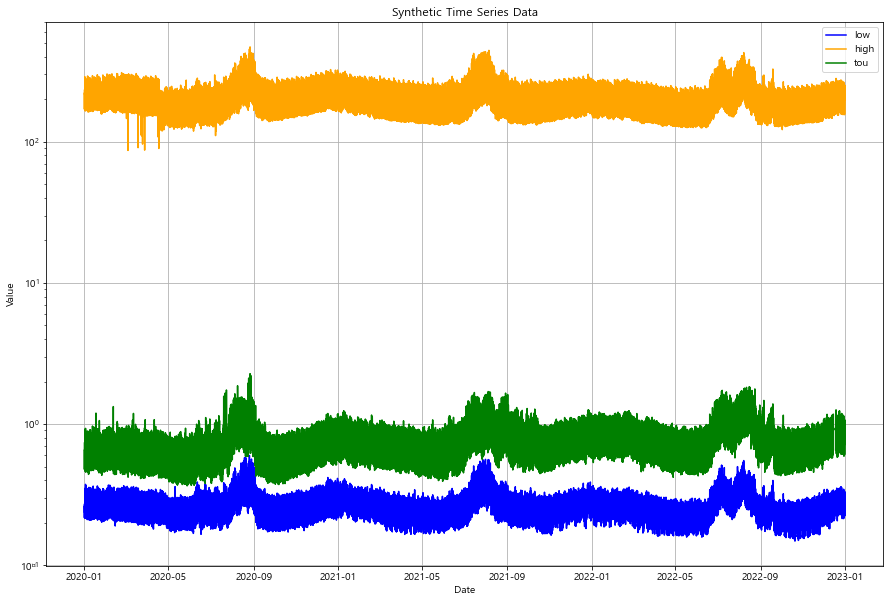

In [69]:
# 시계열 데이터를 화면에 출력한다.
plt.figure(figsize=(15, 10))
plt.plot(low_ts, color='blue', label = 'low')
plt.plot(high_ts, color='orange', label = 'high')
plt.plot(tou_ts, color='green', label = 'tou')
plt.xlabel('Date')
plt.ylabel('Value')

plt.title('Synthetic Time Series Data')
plt.legend()
plt.grid(True)

# Figure2.2020년~2022년 전체(전국 고압, 저압 및 TOU) 일별 시계열 분석 

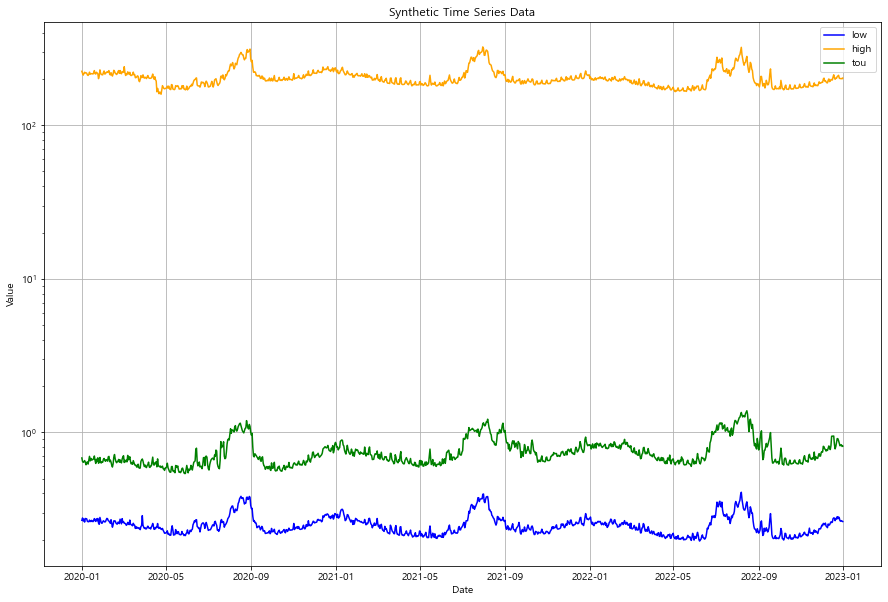

In [83]:
# 시계열 데이터를 화면에 출력한다.
plt.figure(figsize=(15, 10))
plt.plot(low_ts2, color='blue', label = 'low')
plt.plot(high_ts2, color='orange', label = 'high')
plt.plot(tou_ts2, color='green', label = 'tou')
# plt.plot(temp_ts2, color='red', label = '기온')
plt.xlabel('Date')
plt.ylabel('Value')
plt.yscale('log')
plt.title('Synthetic Time Series Data')
plt.legend()
plt.grid(True)

## 2.2 각 데이터의 주기별 시계열 데이터 분석

### 2.2.1 고압

Figure2. 년/월/일/시별 각 그래프 표현

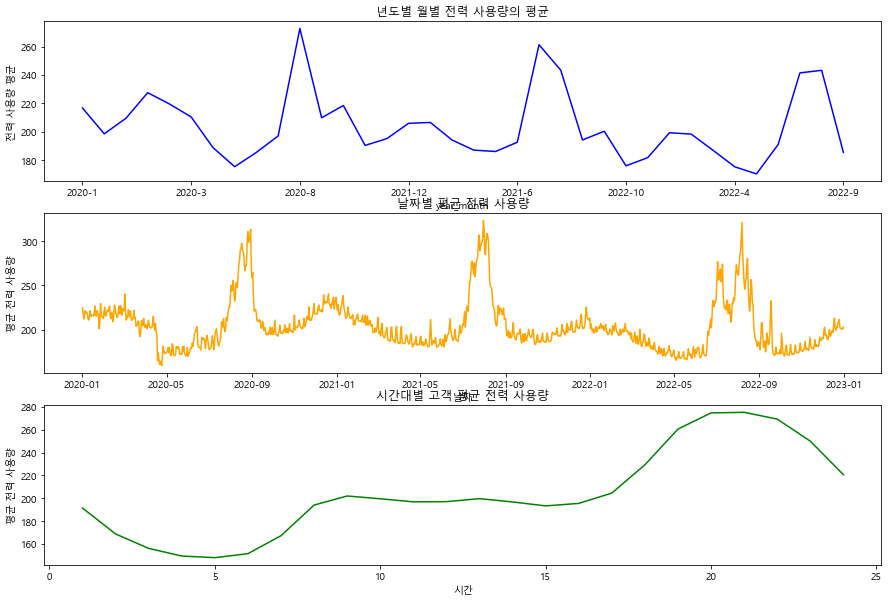

In [260]:
# 년도별 월별 전력 사용량의 평균
yearly_usage_mean = high_df.groupby('year_month')['power'].mean()
daily_avg_usage = high_df.groupby(high_df['date'].dt.date)['power'].mean()
hourly_avg_usage = high_df.groupby('hour')['power'].mean()

# 그래프 그리기
plt.figure(figsize=(15,10))

plt.subplot(3, 1, 1)
yearly_usage_mean.plot(kind='line', color = 'blue')
plt.xlabel('year_month')
plt.ylabel('전력 사용량 평균')
plt.title('년도별 월별 전력 사용량의 평균')



# 날짜별 평균 전력 사용량 계산

# 그래프 그리기
plt.subplot(3, 1, 2)
daily_avg_usage.plot(kind='line', color = 'orange')
plt.title('날짜별 평균 전력 사용량')
plt.xlabel('날짜')
plt.ylabel('평균 전력 사용량')



# 시간대별 고객 평균 전력 사용량

# 그래프 그리기
plt.subplot(3, 1, 3)
hourly_avg_usage.plot(kind='line', color = 'green')
plt.title('시간대별 고객 평균 전력 사용량')
plt.xlabel('시간')
plt.ylabel('평균 전력 사용량')
plt.show()

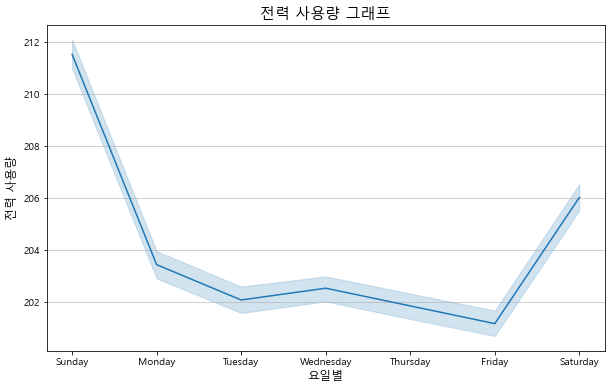

In [269]:
# 요일별

plt.figure(figsize=(10,6))

sns.lineplot(data = high_df, x = 'day_of_week', y = 'power')

plt.title('전력 사용량 그래프', fontsize=15)
plt.xlabel('요일별', fontsize=12)
plt.ylabel('전력 사용량', fontsize=12)
plt.grid(axis='y', alpha=0.75)
plt.show()

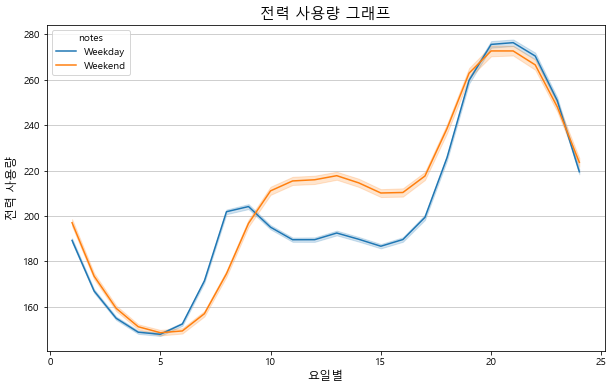

In [270]:
# 시간별 평일/휴일 그래프

plt.figure(figsize=(10,6))

sns.lineplot(data = high_df, x = 'hour', y = 'power', hue = 'notes')

plt.title('전력 사용량 그래프', fontsize=15)
plt.xlabel('요일별', fontsize=12)
plt.ylabel('전력 사용량', fontsize=12)
plt.grid(axis='y', alpha=0.75)
plt.show()

Figure 3. 각 년도 별 그래프 구현

In [127]:
timeseries2020 = high_ts.reset_index()
timeseries2020 = timeseries2020.loc[timeseries2020['date'].dt.year == 2020]
timeseries2020['year'] = '2020'
timeseries2020['month'] = timeseries2020['date'].dt.month
timeseries2020['day'] = timeseries2020['date'].dt.day
timeseries2020['dates'] = pd.to_datetime(timeseries2020[['year', 'month', 'day']])
timeseries2020 = timeseries2020.set_index('dates')['power']

timeseries2021 = high_ts.reset_index()
timeseries2021 = timeseries2021.loc[timeseries2021['date'].dt.year == 2021]
timeseries2021['year'] = '2020'
timeseries2021['month'] = timeseries2021['date'].dt.month
timeseries2021['day'] = timeseries2021['date'].dt.day
timeseries2021['dates'] = pd.to_datetime(timeseries2021[['year', 'month', 'day']])
timeseries2021 = timeseries2021.set_index('dates')['power']

timeseries2022 = high_ts.reset_index()
timeseries2022 = timeseries2022.loc[timeseries2022['date'].dt.year == 2022]
timeseries2022['year'] = '2020'
timeseries2022['month'] = timeseries2022['date'].dt.month
timeseries2022['day'] = timeseries2022['date'].dt.day
timeseries2022['dates'] = pd.to_datetime(timeseries2022[['year', 'month', 'day']])
timeseries2022 = timeseries2022.set_index('dates')['power']

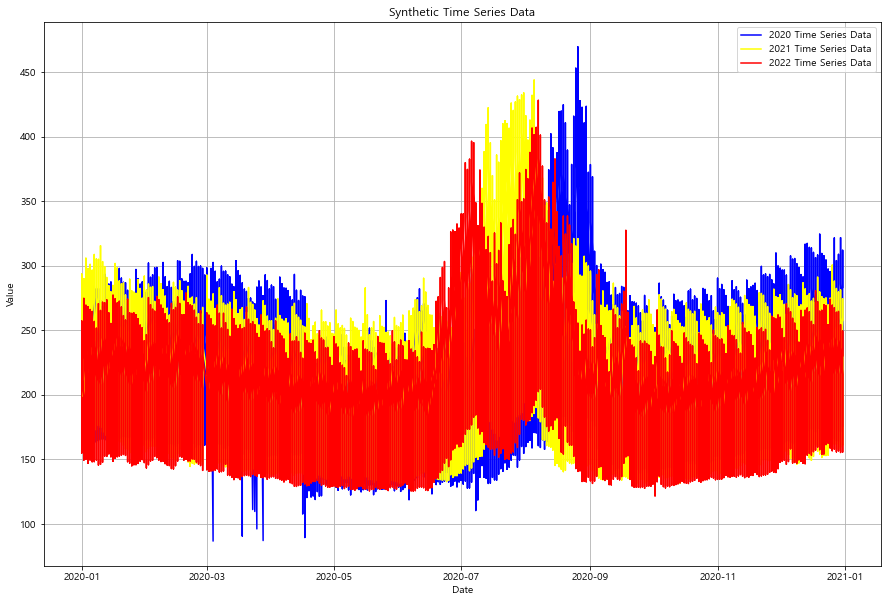

In [128]:
# 시계열 데이터를 화면에 출력한다.
plt.figure(figsize=(15, 10))
plt.plot(timeseries2020, label='2020 Time Series Data', color='blue')
plt.plot(timeseries2021, label='2021 Time Series Data', color='yellow')
plt.plot(timeseries2022, label='2022 Time Series Data', color='red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Synthetic Time Series Data')
plt.legend()
plt.grid(True)

In [135]:
timeseries2020 = high_ts_2.loc[high_ts_2['date'].dt.year == 2020]
timeseries2020['year'] = '2020'
timeseries2020['month'] = timeseries2020['date'].dt.month
timeseries2020['day'] = timeseries2020['date'].dt.day
timeseries2020['dates'] = pd.to_datetime(timeseries2020[['year', 'month', 'day']])
timeseries2020 = timeseries2020.set_index('dates')['power']

timeseries2021 = high_ts_2.loc[high_ts_2['date'].dt.year == 2021]
timeseries2021['year'] = '2020'
timeseries2021['month'] = timeseries2021['date'].dt.month
timeseries2021['day'] = timeseries2021['date'].dt.day
timeseries2021['dates'] = pd.to_datetime(timeseries2021[['year', 'month', 'day']])
timeseries2021 = timeseries2021.set_index('dates')['power']

timeseries2022 = high_ts_2.loc[high_ts_2['date'].dt.year == 2022]
timeseries2022['year'] = '2020'
timeseries2022['month'] = timeseries2022['date'].dt.month
timeseries2022['day'] = timeseries2022['date'].dt.day
timeseries2022['dates'] = pd.to_datetime(timeseries2022[['year', 'month', 'day']])
timeseries2022 = timeseries2022.set_index('dates')['power']

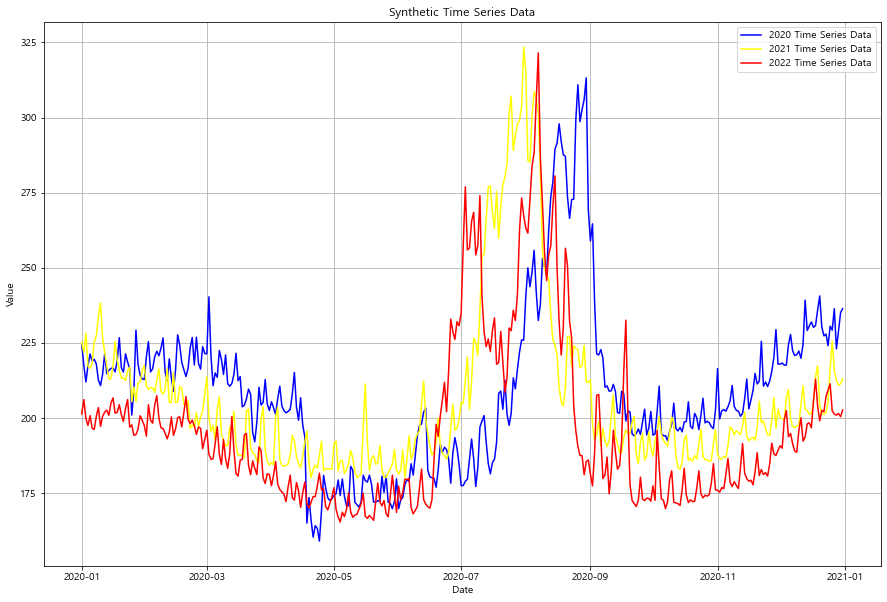

In [136]:
# 시계열 데이터를 화면에 출력한다.
plt.figure(figsize=(15, 10))
plt.plot(timeseries2020, label='2020 Time Series Data', color='blue')
plt.plot(timeseries2021, label='2021 Time Series Data', color='yellow')
plt.plot(timeseries2022, label='2022 Time Series Data', color='red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Synthetic Time Series Data')
plt.legend()
plt.grid(True)

Figure 4. 시계열 분해 시각화

- 일자별 시계열 시각화

<Figure size 432x288 with 0 Axes>

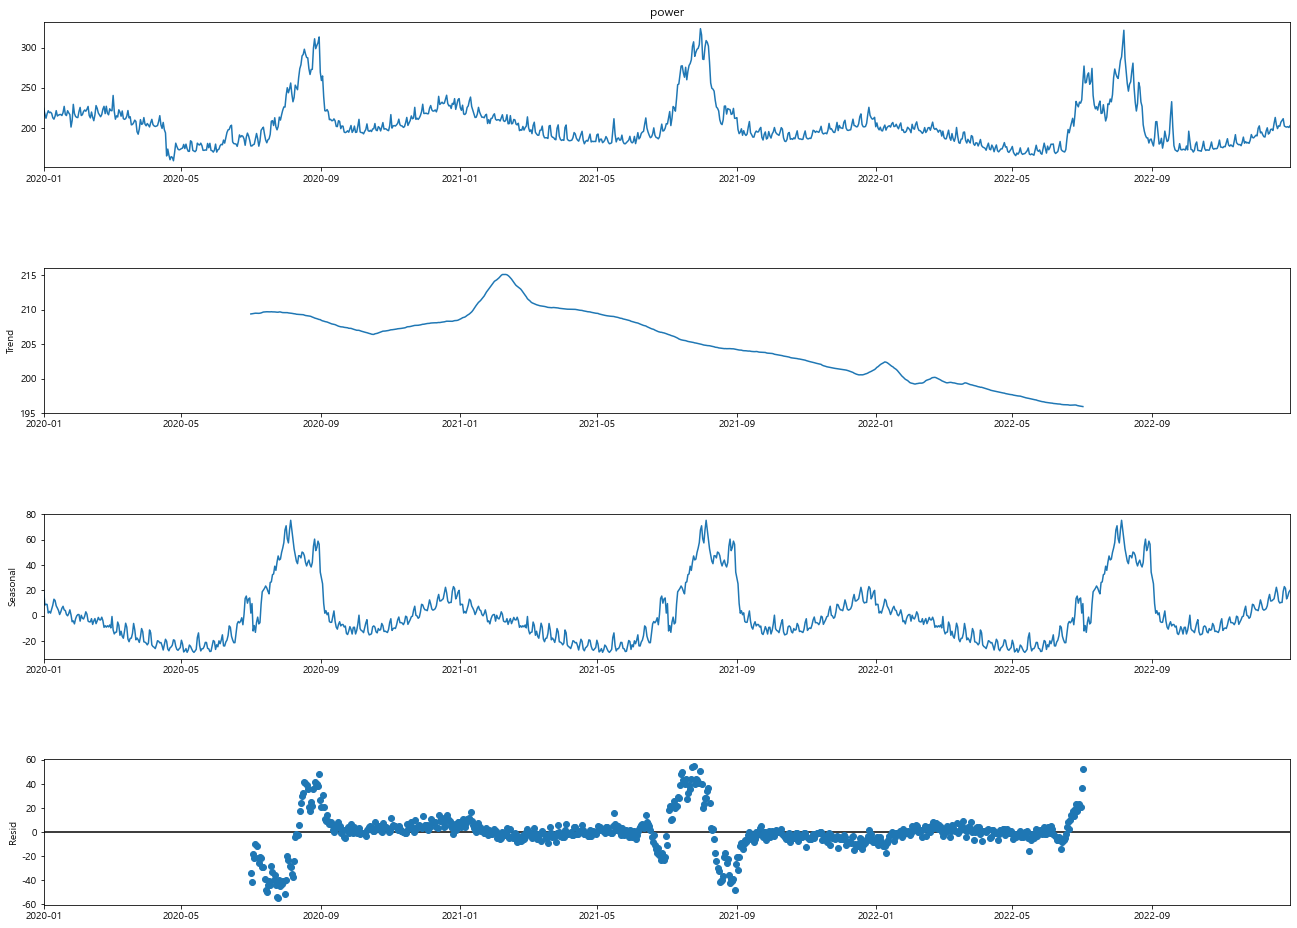

In [249]:
# 시계열 분해 시각화
decomp = seasonal_decompose(high_ts2, model='additive', period=365)

fig = plt.figure()  
fig = decomp.plot()  
- 일자별 시계열 시각화
plt.show()

- 일시별 시계열 시각화

<Figure size 432x288 with 0 Axes>

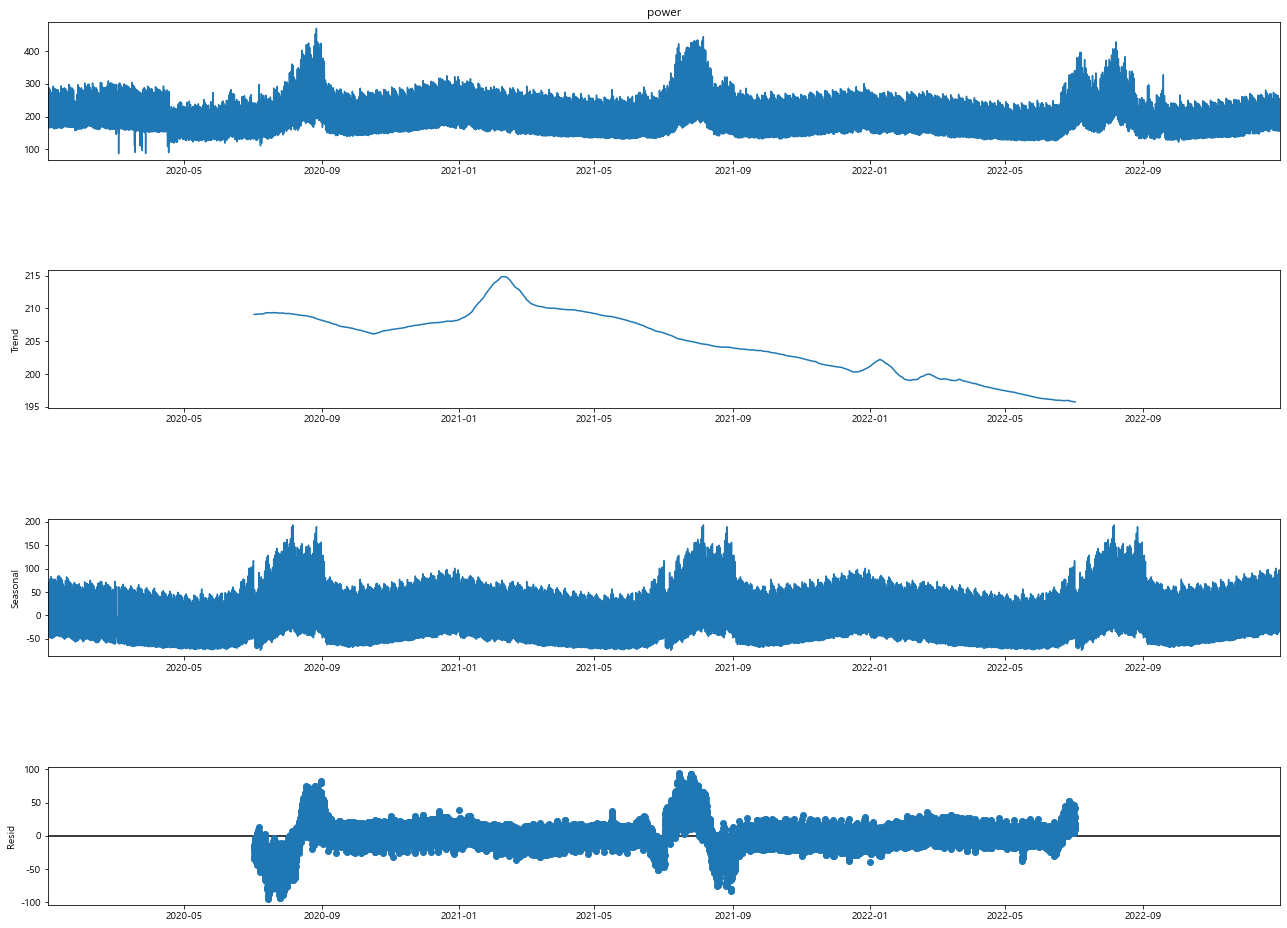

In [251]:
# 시계열 분해 시각화
decomp = seasonal_decompose(high_ts- 일자별 시계열 시각화, model='additive', period=8760)

fig = plt.figure()  
fig = decomp.plot()  
fig.set_size_inches(20, 15)
plt.show()

Figure 5. ACF, PACF 그래프 시각화

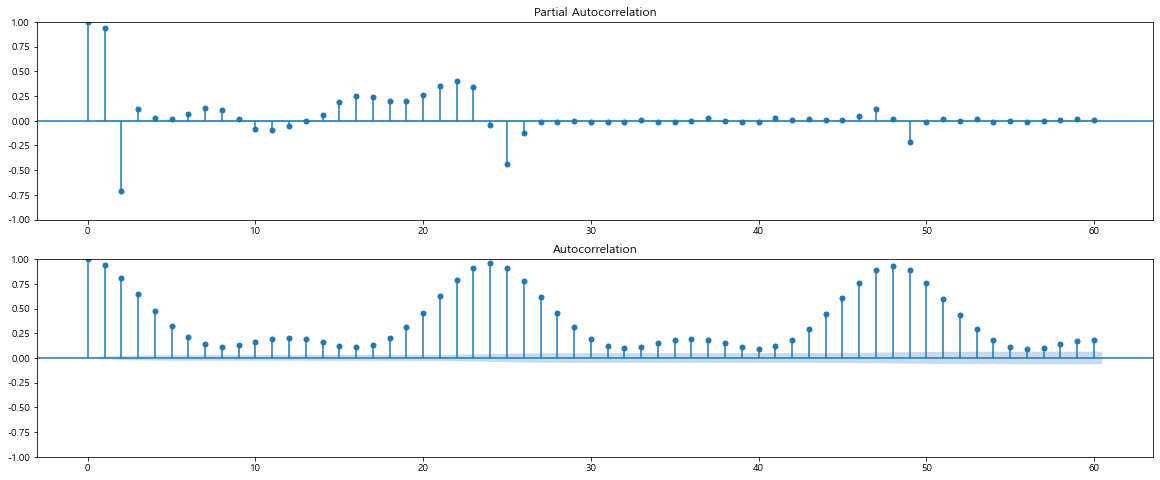

In [103]:
# ACF, PACF 그래프 시각화

fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_acf(low_ts, lags=60, ax=ax1)

ax2 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_pacf(low_ts, lags=60, ax=ax2)

In [105]:
# ADF 검정

# p-value가 0.05 미만이므로 대립가설채택. 즉, 정상성 만족.

def ADF(C): 
    result = adfuller(low_ts.values, autolag="AIC") 
    print("------ Augmented Dickey-Fuller Test ------")
    print('ADF Statistic: %f' % result[0])
    print('p-value: %1.10f' % result[1])
    print('Lag: %d' % result[2])
    print('observation: %d' % result[3])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
 
ADF(low_ts)

------ Augmented Dickey-Fuller Test ------
ADF Statistic: -4.982383
p-value: 0.0000240456
Lag: 49
observation: 26227
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


### 2.2.2 저압

Figure2. 년/월/일/시별 각 그래프 표현

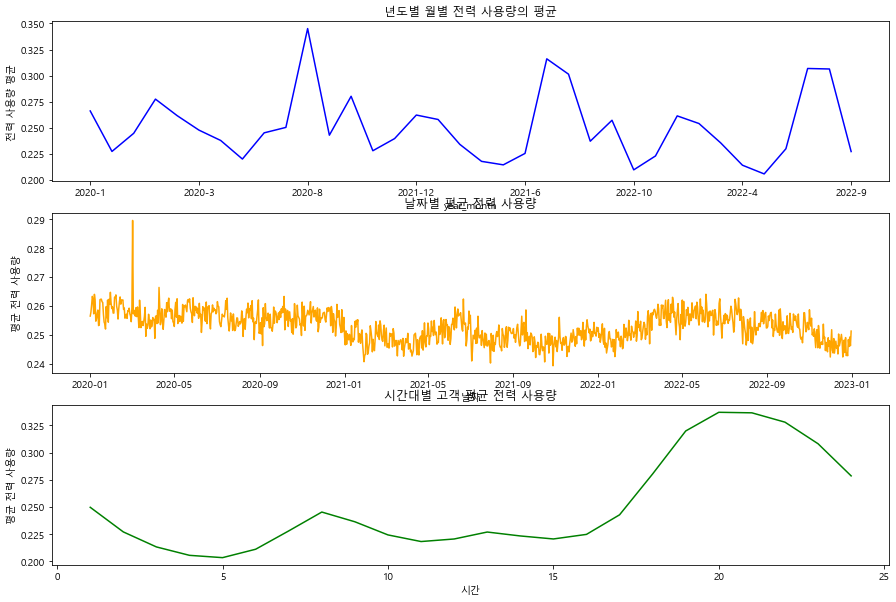

In [268]:
# 년도별 월별 전력 사용량의 평균
yearly_usage_mean = low_df.groupby('year_month')['power'].mean()

# 그래프 그리기
plt.figure(figsize=(15,10))

plt.subplot(3, 1, 1)
yearly_usage_mean.plot(kind='line',  color = 'blue')
plt.xlabel('year_month')
plt.ylabel('전력 사용량 평균')
plt.title('년도별 월별 전력 사용량의 평균')



# 날짜별 평균 전력 사용량 계산
daily_avg_usage = low_df.groupby(high_df['date'].dt.date)['power'].mean()

# 그래프 그리기
plt.subplot(3, 1, 2)
daily_avg_usage.plot(kind='line', color = 'orange')
plt.title('날짜별 평균 전력 사용량')
plt.xlabel('날짜')
plt.ylabel('평균 전력 사용량')



# 시간대별 고객 평균 전력 사용량
hourly_avg_usage = low_df.groupby('hour')['power'].mean()

# 그래프 그리기
plt.subplot(3, 1, 3)
hourly_avg_usage.plot(kind='line', color = 'green')
plt.title('시간대별 고객 평균 전력 사용량')
plt.xlabel('시간')
plt.ylabel('평균 전력 사용량')
plt.show()

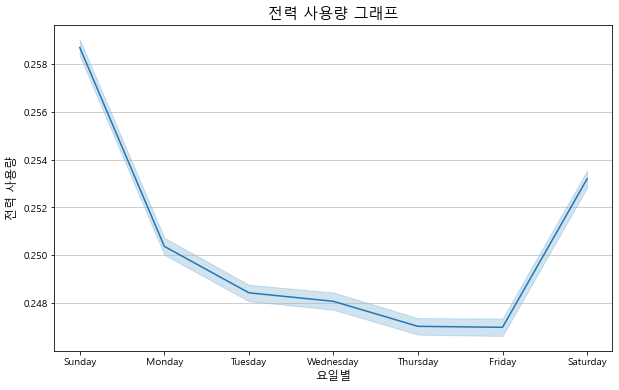

In [20]:
# 요일별

plt.figure(figsize=(10,6))

sns.lineplot(data = low_df, x = 'day_of_week', y = 'power')

plt.title('전력 사용량 그래프', fontsize=15)
plt.xlabel('요일별', fontsize=12)
plt.ylabel('전력 사용량', fontsize=12)
plt.grid(axis='y', alpha=0.75)
plt.show()

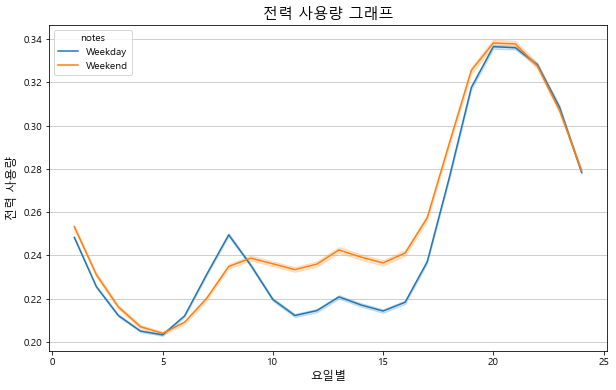

In [21]:
# 시간별 평일/휴일 그래프

plt.figure(figsize=(10,6))

sns.lineplot(data = low_df, x = 'hour', y = 'power', hue = 'notes')

plt.title('전력 사용량 그래프', fontsize=15)
plt.xlabel('요일별', fontsize=12)
plt.ylabel('전력 사용량', fontsize=12)
plt.grid(axis='y', alpha=0.75)
plt.show()

Figure 3. 각 년도 별 그래프 구현

In [127]:
timeseries2020 = low_ts.reset_index()
timeseries2020 = timeseries2020.loc[timeseries2020['date'].dt.year == 2020]
timeseries2020['year'] = '2020'
timeseries2020['month'] = timeseries2020['date'].dt.month
timeseries2020['day'] = timeseries2020['date'].dt.day
timeseries2020['dates'] = pd.to_datetime(timeseries2020[['year', 'month', 'day']])
timeseries2020 = timeseries2020.set_index('dates')['power']

timeseries2021 = low_ts.reset_index()
timeseries2021 = timeseries2021.loc[timeseries2021['date'].dt.year == 2021]
timeseries2021['year'] = '2020'
timeseries2021['month'] = timeseries2021['date'].dt.month
timeseries2021['day'] = timeseries2021['date'].dt.day
timeseries2021['dates'] = pd.to_datetime(timeseries2021[['year', 'month', 'day']])
timeseries2021 = timeseries2021.set_index('dates')['power']

timeseries2022 = low_ts.reset_index()
timeseries2022 = timeseries2022.loc[timeseries2022['date'].dt.year == 2022]
timeseries2022['year'] = '2020'
timeseries2022['month'] = timeseries2022['date'].dt.month
timeseries2022['day'] = timeseries2022['date'].dt.day
timeseries2022['dates'] = pd.to_datetime(timeseries2022[['year', 'month', 'day']])
timeseries2022 = timeseries2022.set_index('dates')['power']

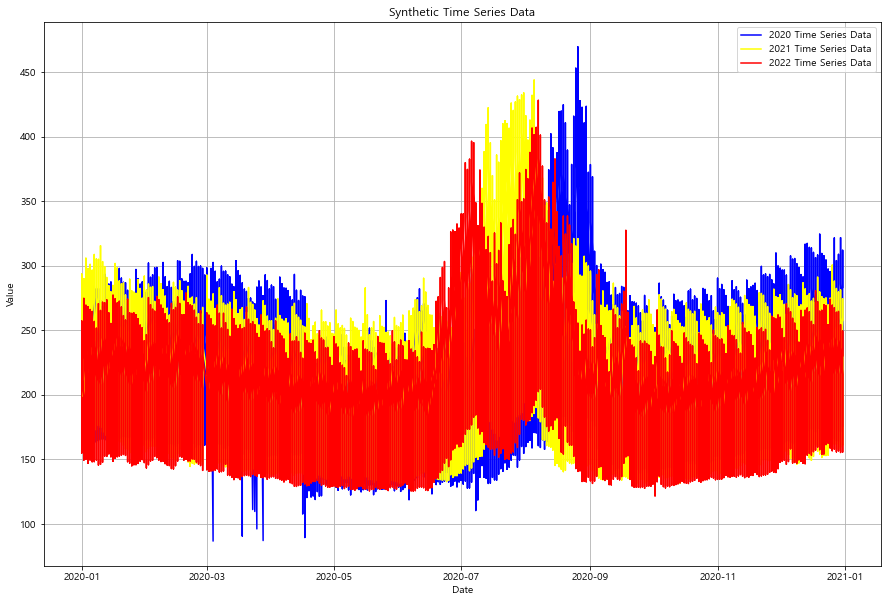

In [128]:
# 시계열 데이터를 화면에 출력한다.
plt.figure(figsize=(15, 10))
plt.plot(timeseries2020, label='2020 Time Series Data', color='blue')
plt.plot(timeseries2021, label='2021 Time Series Data', color='yellow')
plt.plot(timeseries2022, label='2022 Time Series Data', color='red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Synthetic Time Series Data')
plt.legend()
plt.grid(True)

In [135]:
timeseries2020 = low_ts_2.loc[low_ts_2['date'].dt.year == 2020]
timeseries2020['year'] = '2020'
timeseries2020['month'] = timeseries2020['date'].dt.month
timeseries2020['day'] = timeseries2020['date'].dt.day
timeseries2020['dates'] = pd.to_datetime(timeseries2020[['year', 'month', 'day']])
timeseries2020 = timeseries2020.set_index('dates')['power']

timeseries2021 = low_ts_2.loc[low_ts_2['date'].dt.year == 2021]
timeseries2021['year'] = '2020'
timeseries2021['month'] = timeseries2021['date'].dt.month
timeseries2021['day'] = timeseries2021['date'].dt.day
timeseries2021['dates'] = pd.to_datetime(timeseries2021[['year', 'month', 'day']])
timeseries2021 = timeseries2021.set_index('dates')['power']

timeseries2022 = low_ts_2.loc[low_ts_2['date'].dt.year == 2022]
timeseries2022['year'] = '2020'
timeseries2022['month'] = timeseries2022['date'].dt.month
timeseries2022['day'] = timeseries2022['date'].dt.day
timeseries2022['dates'] = pd.to_datetime(timeseries2022[['year', 'month', 'day']])
timeseries2022 = timeseries2022.set_index('dates')['power']

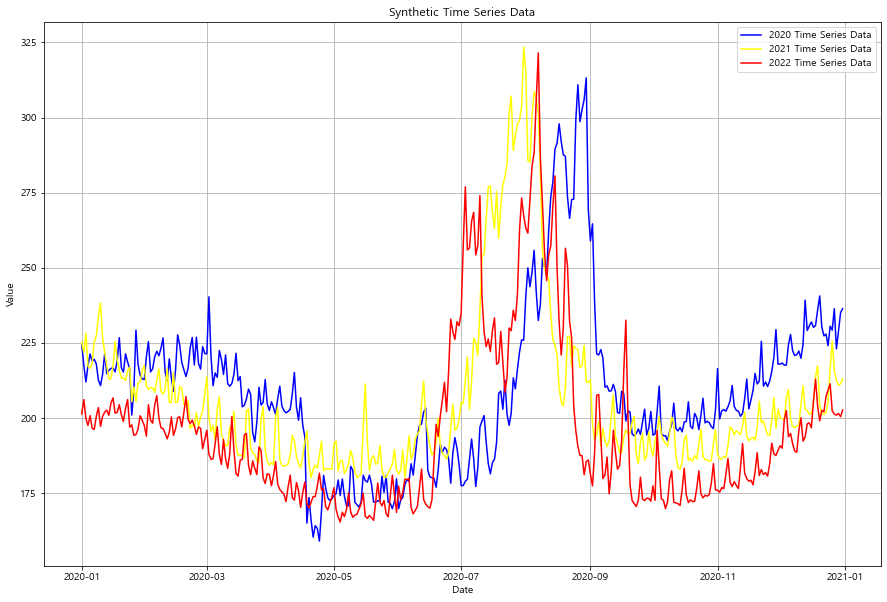

In [136]:
# 시계열 데이터를 화면에 출력한다.
plt.figure(figsize=(15, 10))
plt.plot(timeseries2020, label='2020 Time Series Data', color='blue')
plt.plot(timeseries2021, label='2021 Time Series Data', color='yellow')
plt.plot(timeseries2022, label='2022 Time Series Data', color='red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Synthetic Time Series Data')
plt.legend()
plt.grid(True)

Figure 4. 시계열 분해 시각화

- 일자별 시계열 시각화

<Figure size 432x288 with 0 Axes>

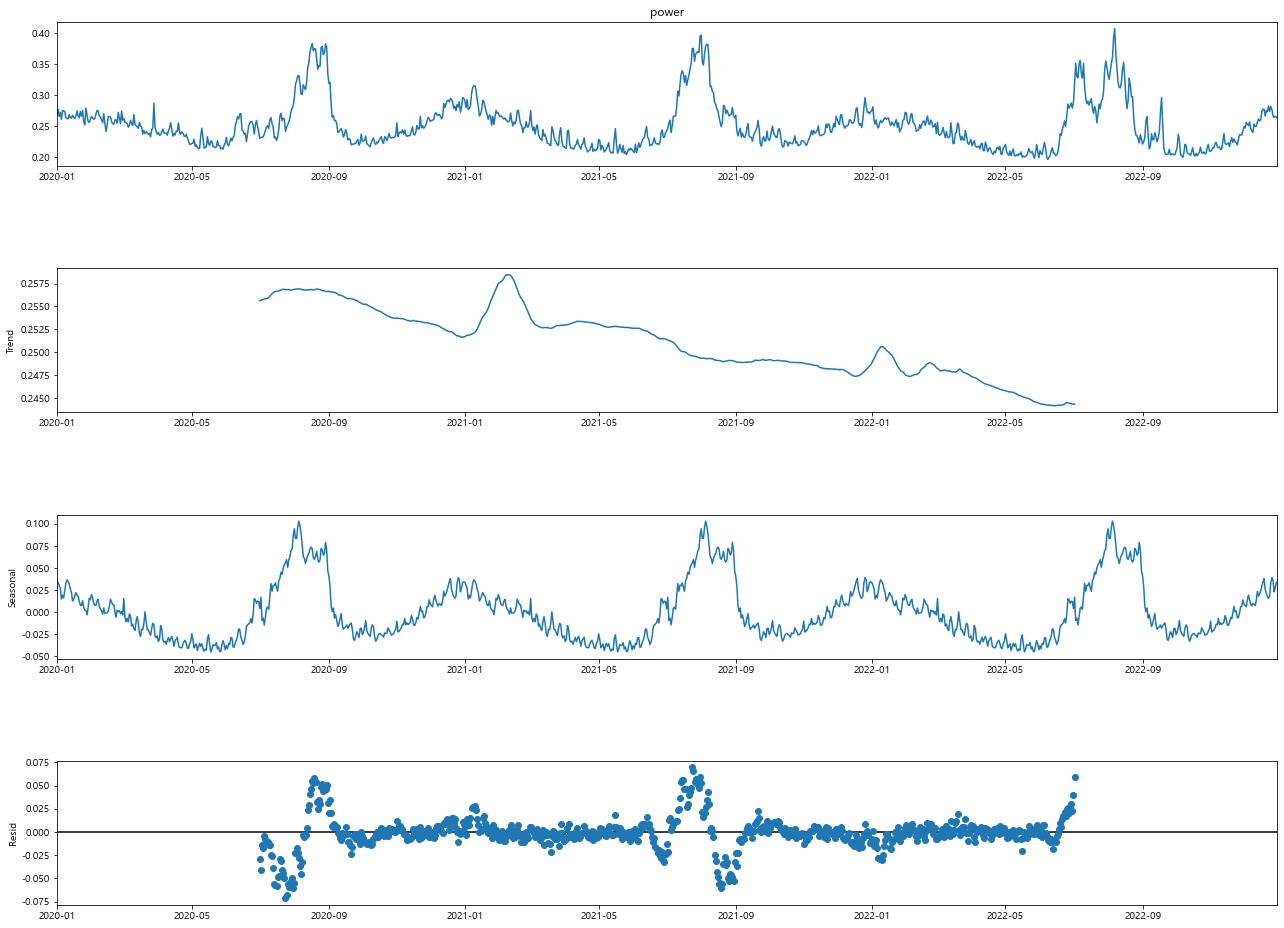

In [247]:
# 시계열 분해 시각화
decomp = seasonal_decompose(low_ts2, model='additive', period=365- 일자별 시계열 시각화)

fig = plt.figure()  
fig = decomp.plot()  
fig.set_size_inches(20, 15)
plt.show()

- 일시별 시계열 시각화

<Figure size 432x288 with 0 Axes>

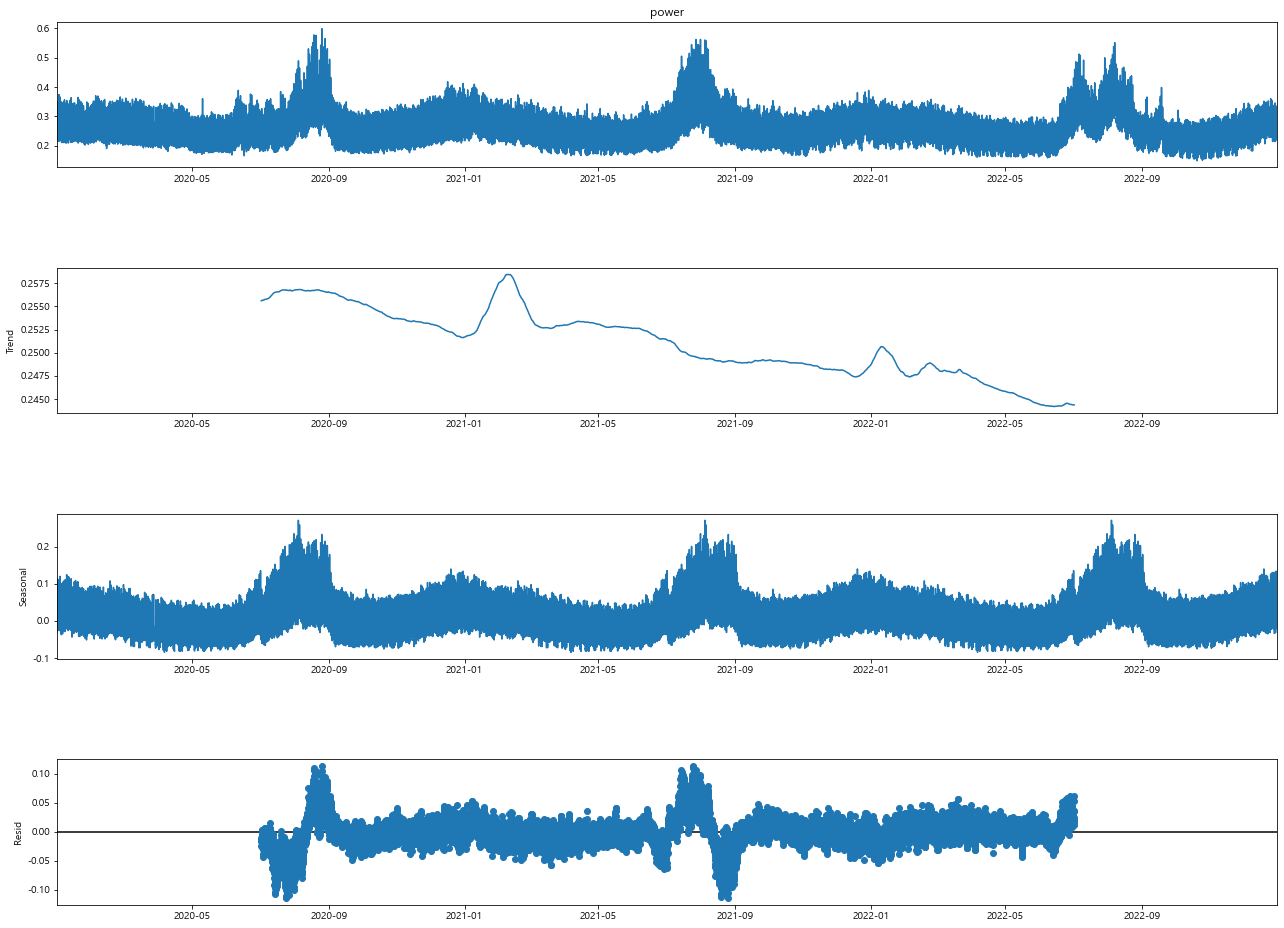

In [115]:
# 시계열 분해 시각화
decomp = seasonal_decompose(low_ts, model='additive', period=8760)

fig = plt.figure()  
fig = decomp.plot()  
fig.set_size_inches(20, 15)
plt.show()

Figure 5. ACF, PACF 그래프 시각화

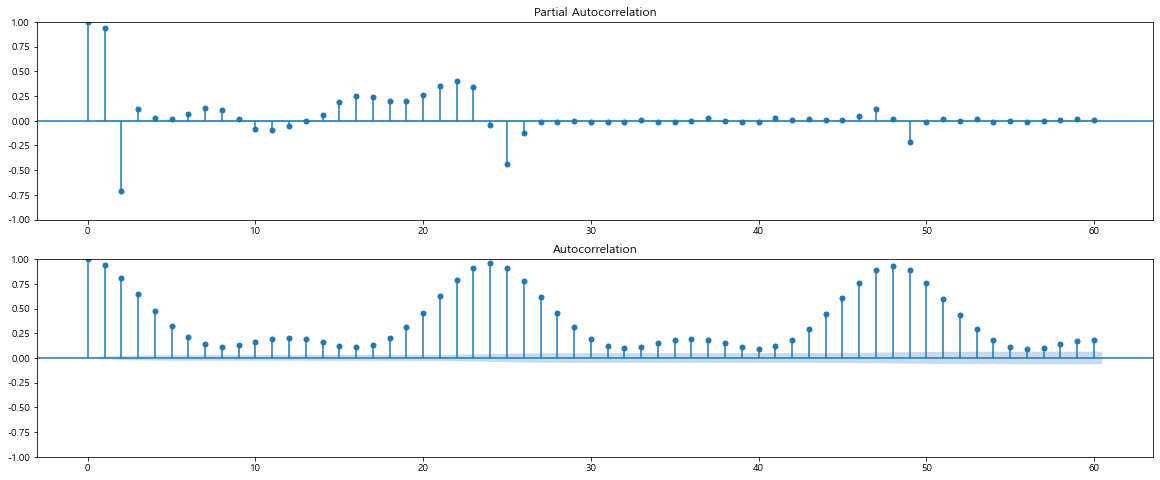

In [117]:
# ACF, PACF 그래프 시각화

fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_acf(low_ts, lags=60, ax=ax1)

ax2 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_pacf(low_ts, lags=60, ax=ax2)

In [119]:
# ADF 검정

# p-value가 0.05 미만이므로 대립가설채택. 즉, 정상성 만족.

def ADF(C): 
    result = adfuller(C.values, autolag="AIC") 
    print("------ Augmented Dickey-Fuller Test ------")
    print('ADF Statistic: %f' % result[0])
    print('p-value: %1.10f' % result[1])
    print('Lag: %d' % result[2])
    print('observation: %d' % result[3])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
 
ADF(low_ts)

------ Augmented Dickey-Fuller Test ------
ADF Statistic: -4.982383
p-value: 0.0000240456
Lag: 49
observation: 26227
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


### 2.2.3 TOU

# Figure. 년/월/일/시별 각 그래프 표현

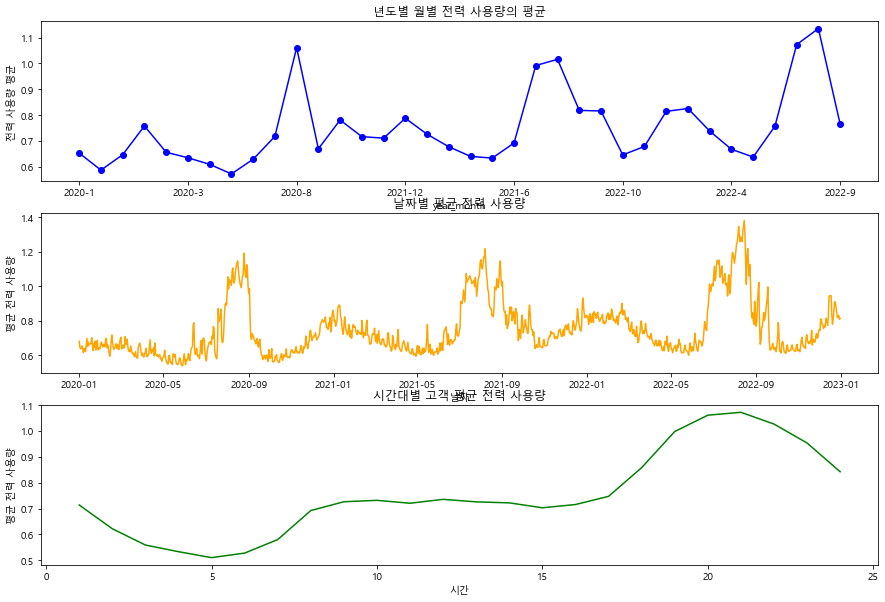

In [267]:
# 년도별 월별 전력 사용량의 평균
yearly_usage_mean = tou_df.groupby('year_month')['power'].mean()

# 그래프 그리기
plt.figure(figsize=(15,10))

plt.subplot(3, 1, 1)
yearly_usage_mean.plot(kind='line', marker='o', color = 'blue')
plt.xlabel('year_month')
plt.ylabel('전력 사용량 평균')
plt.title('년도별 월별 전력 사용량의 평균')



# 날짜별 평균 전력 사용량 계산
daily_avg_usage = tou_df.groupby(tou_df['date'].dt.date)['power'].mean()

# 그래프 그리기
plt.subplot(3, 1, 2)
daily_avg_usage.plot(kind='line', color = 'orange')
plt.title('날짜별 평균 전력 사용량')
plt.xlabel('날짜')
plt.ylabel('평균 전력 사용량')



# 시간대별 고객 평균 전력 사용량
hourly_avg_usage = tou_df.groupby('hour')['power'].mean()

# 그래프 그리기
plt.subplot(3, 1, 3)
hourly_avg_usage.plot(kind='line', color = 'green')
plt.title('시간대별 고객 평균 전력 사용량')
plt.xlabel('시간')
plt.ylabel('평균 전력 사용량')
plt.show()

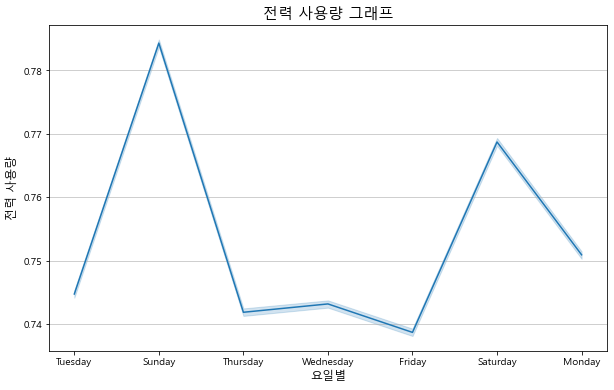

In [22]:
# 요일별

plt.figure(figsize=(10,6))

sns.lineplot(data = tou_df, x = 'day_of_week', y = 'power')

plt.title('전력 사용량 그래프', fontsize=15)
plt.xlabel('요일별', fontsize=12)
plt.ylabel('전력 사용량', fontsize=12)
plt.grid(axis='y', alpha=0.75)
plt.show()

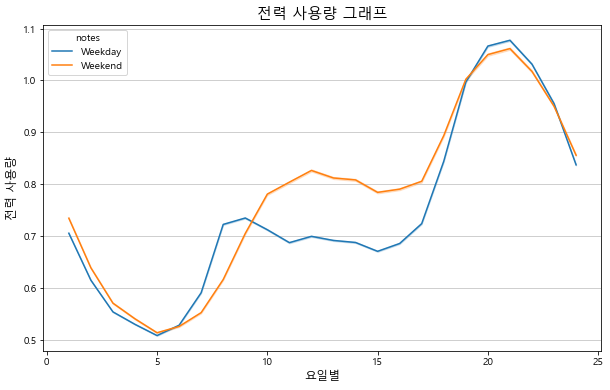

In [23]:
# 시간별 평일/휴일 그래프

plt.figure(figsize=(10,6))

sns.lineplot(data = tou_df, x = 'hour', y = 'power', hue = 'notes')

plt.title('전력 사용량 그래프', fontsize=15)
plt.xlabel('요일별', fontsize=12)
plt.ylabel('전력 사용량', fontsize=12)
plt.grid(axis='y', alpha=0.75)
plt.show()

# Figure 3. 각 년도 별 그래프 구현

In [304]:
timeseries2020 = tou_ts.reset_index()
timeseries2020 = timeseries2020.loc[timeseries2020['date'].dt.year == 2020]
timeseries2020['year'] = '2020'
timeseries2020['month'] = timeseries2020['date'].dt.month
timeseries2020['day'] = timeseries2020['date'].dt.day
timeseries2020['dates'] = pd.to_datetime(timeseries2020[['year', 'month', 'day']])
timeseries2020 = timeseries2020.set_index('dates')['power']

timeseries2021 = tou_ts.reset_index()
timeseries2021 = timeseries2021.loc[timeseries2021['date'].dt.year == 2021]
timeseries2021['year'] = '2020'
timeseries2021['month'] = timeseries2021['date'].dt.month
timeseries2021['day'] = timeseries2021['date'].dt.day
timeseries2021['dates'] = pd.to_datetime(timeseries2021[['year', 'month', 'day']])
timeseries2021 = timeseries2021.set_index('dates')['power']

timeseries2022 = tou_ts.reset_index()
timeseries2022 = timeseries2022.loc[timeseries2022['date'].dt.year == 2022]
timeseries2022['year'] = '2020'
timeseries2022['month'] = timeseries2022['date'].dt.month
timeseries2022['day'] = timeseries2022['date'].dt.day
timeseries2022['dates'] = pd.to_datetime(timeseries2022[['year', 'month', 'day']])
timeseries2022 = timeseries2022.set_index('dates')['power']

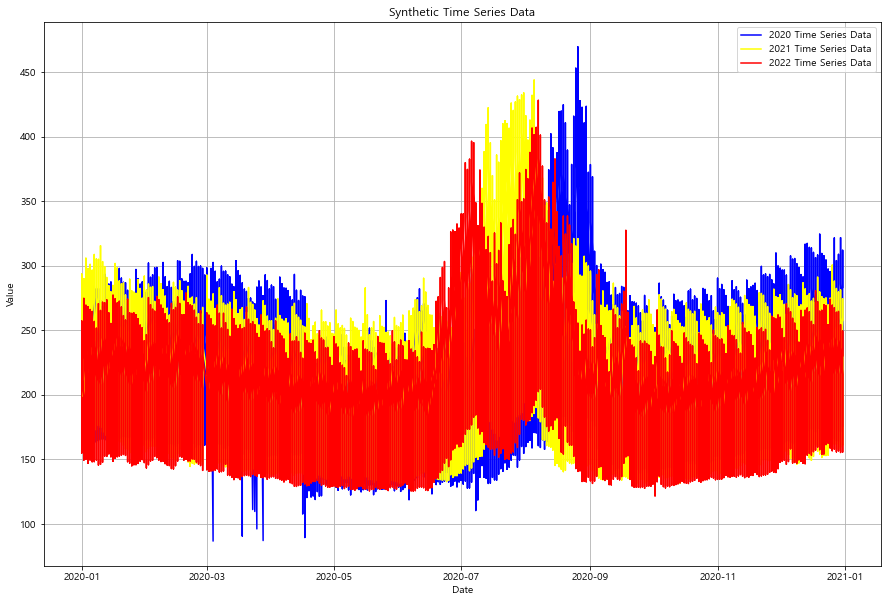

In [128]:
# 시계열 데이터를 화면에 출력한다.
plt.figure(figsize=(15, 10))
plt.plot(timeseries2020, label='2020 Time Series Data', color='blue')
plt.plot(timeseries2021, label='2021 Time Series Data', color='yellow')
plt.plot(timeseries2022, label='2022 Time Series Data', color='red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Synthetic Time Series Data')
plt.legend()
plt.grid(True)

In [135]:
timeseries2020 = tou_ts2.loc[high_ts_2['date'].dt.year == 2020]
timeseries2020['year'] = '2020'
timeseries2020['month'] = timeseries2020['date'].dt.month
timeseries2020['day'] = timeseries2020['date'].dt.day
timeseries2020['dates'] = pd.to_datetime(timeseries2020[['year', 'month', 'day']])
timeseries2020 = timeseries2020.set_index('dates')['power']

timeseries2021 = tou_ts2.loc[high_ts_2['date'].dt.year == 2021]
timeseries2021['year'] = '2020'
timeseries2021['month'] = timeseries2021['date'].dt.month
timeseries2021['day'] = timeseries2021['date'].dt.day
timeseries2021['dates'] = pd.to_datetime(timeseries2021[['year', 'month', 'day']])
timeseries2021 = timeseries2021.set_index('dates')['power']

timeseries2022 = tou_ts2.loc[high_ts_2['date'].dt.year == 2022]
timeseries2022['year'] = '2020'
timeseries2022['month'] = timeseries2022['date'].dt.month
timeseries2022['day'] = timeseries2022['date'].dt.day
timeseries2022['dates'] = pd.to_datetime(timeseries2022[['year', 'month', 'day']])
timeseries2022 = timeseries2022.set_index('dates')['power']

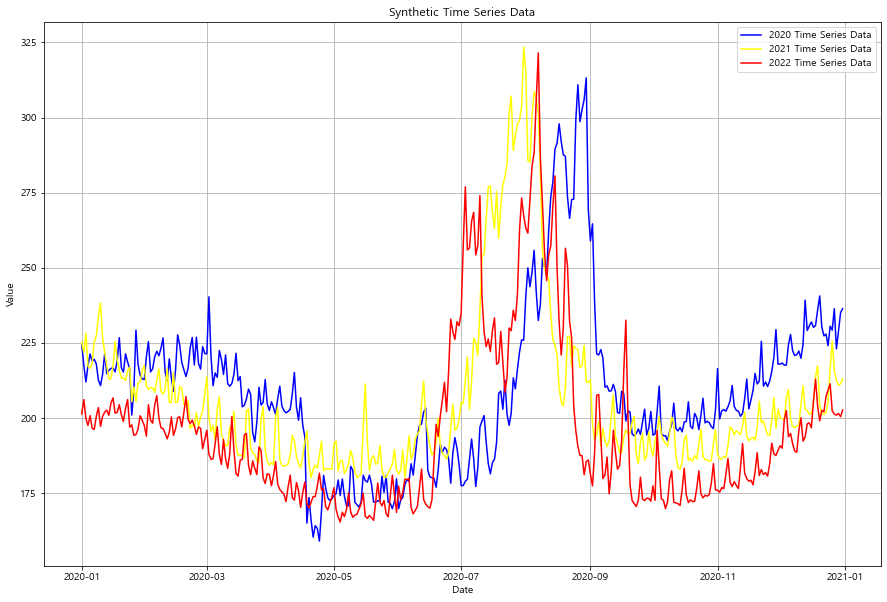

In [136]:
# 시계열 데이터를 화면에 출력한다.
plt.figure(figsize=(15, 10))
plt.plot(timeseries2020, label='2020 Time Series Data', color='blue')
plt.plot(timeseries2021, label='2021 Time Series Data', color='yellow')
plt.plot(timeseries2022, label='2022 Time Series Data', color='red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Synthetic Time Series Data')
plt.legend()
plt.grid(True)

Figure 4. 시계열 분해 시각화

- 일자별 시계열 시각화

<Figure size 432x288 with 0 Axes>

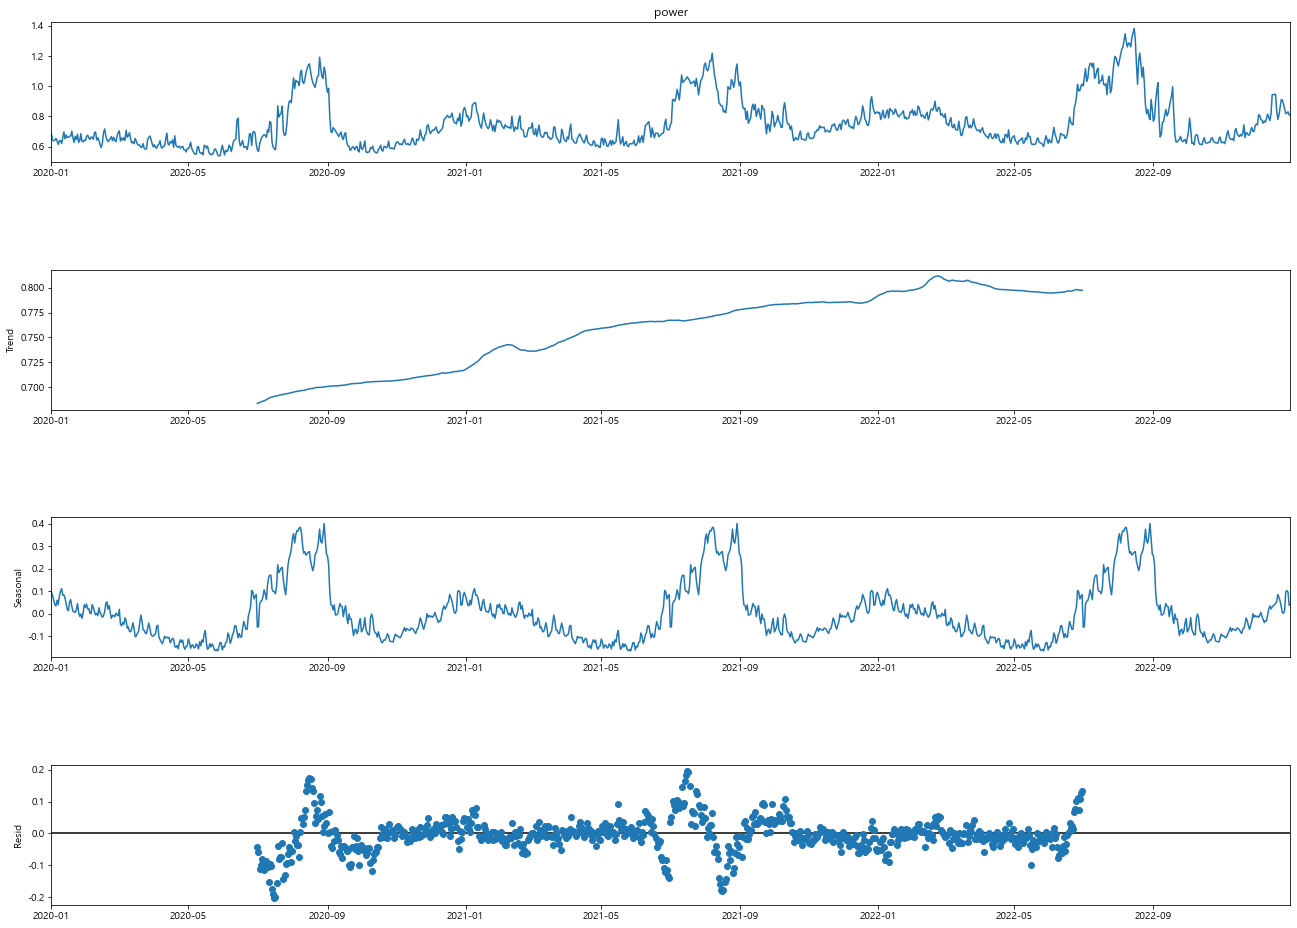

In [243]:
# 시계열 분해 시각화
decomp = seasonal_decompose(tou_ts2, model='additive', period=365)

fig = plt.figure()  
fig = decomp.plot(- 일자별 시계열 시각화)  
fig.set_size_inches(20, 15)
plt.show()

- 일시별 시계열 시각화

<Figure size 432x288 with 0 Axes>

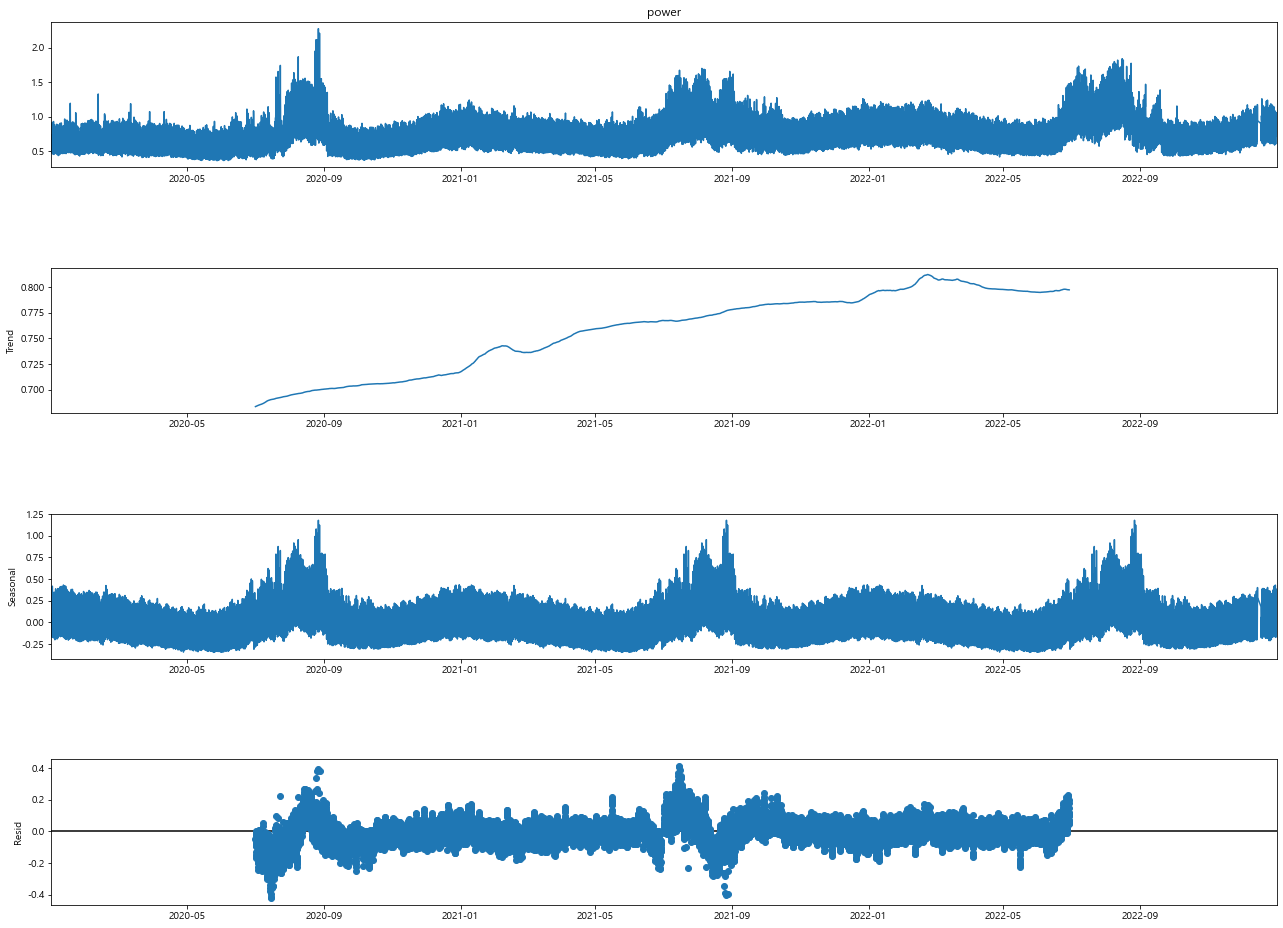

In [245]:
# 시계열 분해 시각화
decomp = seasonal_decompose(tou_ts, model='additive', period=8760)

fig = plt.figure()  
fig = decomp.plot(- 일자별 시계열 시각화)  
fig.set_size_inches(20, 15)
plt.show()

Figure 5. ACF, PACF 그래프 시각화

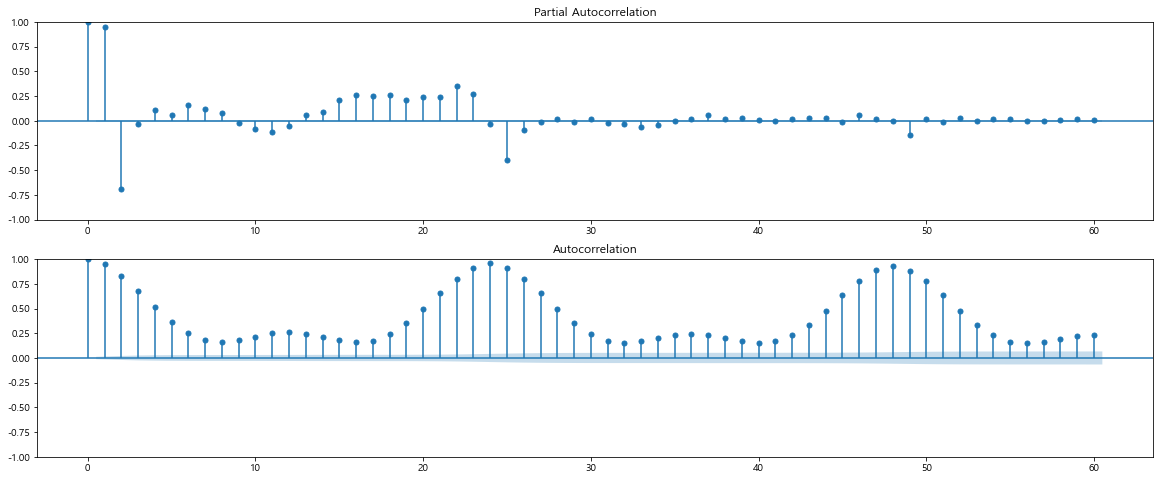

In [132]:
# ACF, PACF 그래프 시각화

fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_acf(tou_ts, lags=60, ax=ax1)

ax2 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_pacf(tou_ts, lags=60, ax=ax2)

In [133]:
# ADF 검정

# p-value가 0.05 미만이므로 대립가설채택. 즉, 정상성 만족.

def ADF(C): 
    result = adfuller(C.values, autolag="AIC") 
    print("------ Augmented Dickey-Fuller Test ------")
    print('ADF Statistic: %f' % result[0])
    print('p-value: %1.10f' % result[1])
    print('Lag: %d' % result[2])
    print('observation: %d' % result[3])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
 
ADF(tou_ts)

------ Augmented Dickey-Fuller Test ------
ADF Statistic: -4.631779
p-value: 0.0001128251
Lag: 49
observation: 26179
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


# 3. ARIMA 시계열 데이터 모델링
### 3.1전국 시도별 고압 ARIMA 

In [271]:
# ARIMA용 학습셋, 테스트셋 생성

train= high_ts.loc['2020-01-01':'2021-12-31']
test= high_ts.loc['2022-01-01':'2022-12-31']

# 학습셋과 검증셋이 잘 나뉘었는지 확인
print('train data 개수: ', len(train))
print('test data 개수: ', len(test))

train data 개수:  17518
test data 개수:  8759


In [272]:
# ARIMA 예측값 출력

# p,d,q 파라미터값 설정
p, d, q = 3, 0, 3

model_arima = ARIMA(high_ts, order=(p,d,q)) 
model_arima_fit = model_arima.fit()

# 예측값 출력

#pred1=model_arima_fit.predict(start=8759,end=8759+len(test)-1,typ='levels')

pred1 = model_arima_fit.predict(start = '2022-01-01', end ='2022-12-31')
pred = pd.Series(pred1, index=test.index)

print(np.round_(pred,2))

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



date
2022-01-01 01:00:00    240.95
2022-01-01 02:00:00    153.34
2022-01-01 03:00:00    167.29
2022-01-01 04:00:00    155.06
2022-01-01 05:00:00    160.63
                        ...  
2022-12-31 19:00:00       NaN
2022-12-31 20:00:00       NaN
2022-12-31 21:00:00       NaN
2022-12-31 22:00:00       NaN
2022-12-31 23:00:00       NaN
Name: predicted_mean, Length: 8759, dtype: float64


<AxesSubplot:xlabel='date'>

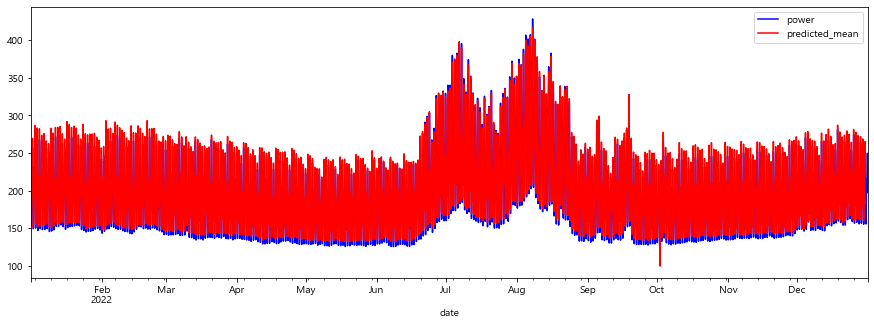

In [273]:
# ARIMA 모델 예측값 시각화

fig, ax = plt.subplots(figsize=(15,5))
#graph = sns.lineplot(x='date', y='power', data = train)

#test.plot(ax=ax, color='red', legend=True)
test.plot(ax=ax, color='blue', legend=True)
pred.plot(ax=ax, color='red', legend=True)

In [274]:
# ARIMA 모델 요약

print(model_arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  power   No. Observations:                26277
Model:                 ARIMA(3, 0, 3)   Log Likelihood             -100807.949
Date:                Fri, 10 Nov 2023   AIC                         201631.897
Time:                        13:04:12   BIC                         201697.309
Sample:                             0   HQIC                        201653.019
                              - 26277                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        203.6838      0.921    221.062      0.000     201.878     205.490
ar.L1          2.4510      0.014    176.249      0.000       2.424       2.478
ar.L2         -2.1805      0.024    -92.354      0.0

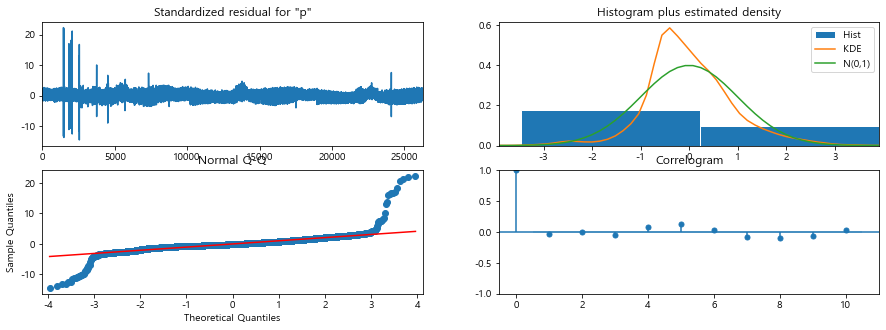

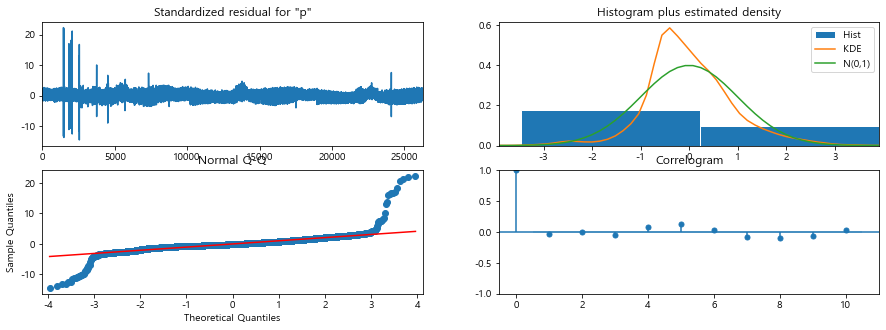

In [275]:
model_arima_fit.plot_diagnostics(figsize=(15,5))

In [276]:
#1년치 미래 예측
future_index=pd.date_range(start='2023-01-01',end='2024-01-01',freq='H')
future_forecast=model_arima_fit.predict(start=8761,end=8761+len(future_index)-1,typ='levels')

#데이터프레임 
high_forecast_df=pd.DataFrame({'Datetime':future_index, 'power':future_forecast})
high_forecast_df.reset_index(drop=True, inplace=True)
high_forecast_df

,Datetime,power
0,2023-01-01 00:00:00,179.465056
1,2023-01-01 01:00:00,169.251176
2,2023-01-01 02:00:00,176.358624
3,2023-01-01 03:00:00,172.244506
4,2023-01-01 04:00:00,173.186271
...,...,...
8756,2023-12-31 20:00:00,259.039625
8757,2023-12-31 21:00:00,240.953040
8758,2023-12-31 22:00:00,153.341502
8759,2023-12-31 23:00:00,167.287810


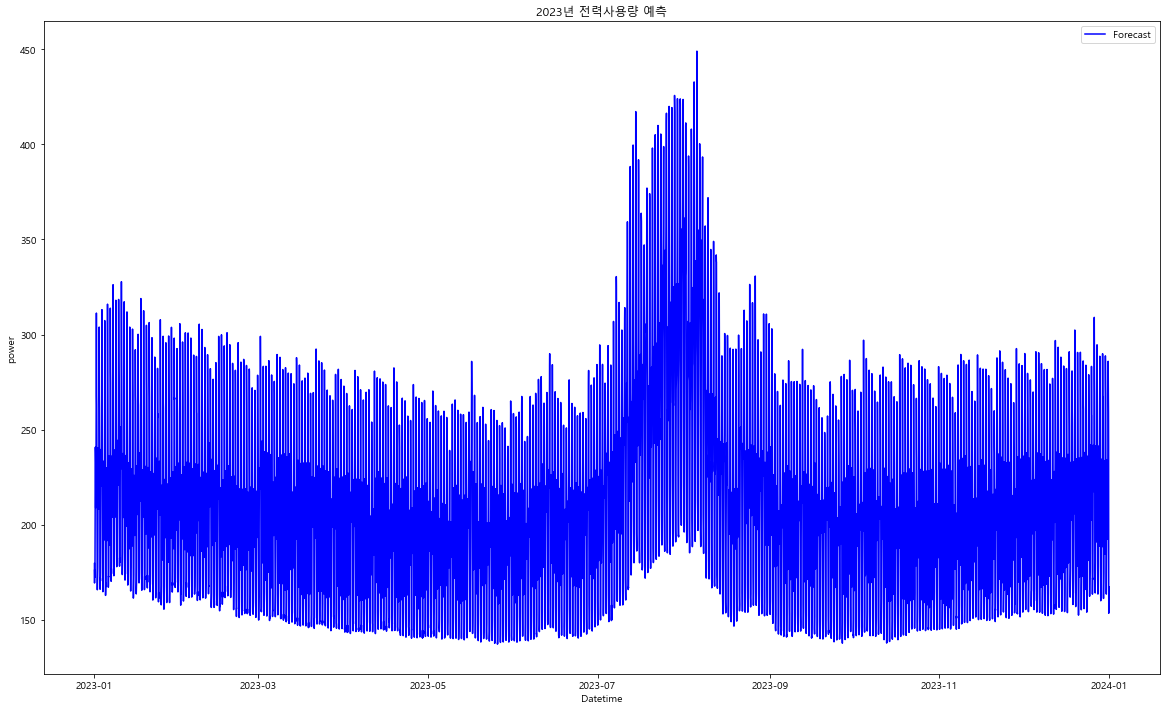

In [277]:
# 그래프 그리기
plt.figure(figsize=(20, 12))
plt.plot(high_forecast_df['Datetime'], high_forecast_df['power'], label='Forecast', color='blue')
plt.legend()
plt.xlabel('Datetime')
plt.ylabel('power')
plt.title('2023년 전력사용량 예측')
plt.show()

## 3.2 전국 시도별 저압 ARIMA 

In [278]:
# ARIMA용 학습셋, 테스트셋 생성

train= low_ts.loc['2020-01-01':'2021-12-31']
test= low_ts.loc['2022-01-01':'2022-12-31']

# 학습셋과 검증셋이 잘 나뉘었는지 확인
print('train data 개수: ', len(train))
print('test data 개수: ', len(test))

train data 개수:  17518
test data 개수:  8759


In [279]:
# ARIMA 예측값 출력

# p,d,q 파라미터값 설정
p, d, q = 3, 0, 3

model_arima = ARIMA(low_ts, order=(p,d,q)) 
model_arima_fit = model_arima.fit()

# 예측값 출력

#pred1=model_arima_fit.predict(start=8759,end=8759+len(test)-1,typ='levels')

pred1 = model_arima_fit.predict(start = '2022-01-01', end ='2022-12-31', typ = 'level')
pred = pd.Series(pred1, index=test.index)

print(np.round_(pred,2))

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



date
2022-01-01 01:00:00    0.32
2022-01-01 02:00:00    0.23
2022-01-01 03:00:00    0.24
2022-01-01 04:00:00    0.23
2022-01-01 05:00:00    0.22
                       ... 
2022-12-31 19:00:00     NaN
2022-12-31 20:00:00     NaN
2022-12-31 21:00:00     NaN
2022-12-31 22:00:00     NaN
2022-12-31 23:00:00     NaN
Name: predicted_mean, Length: 8759, dtype: float64


<AxesSubplot:xlabel='date'>

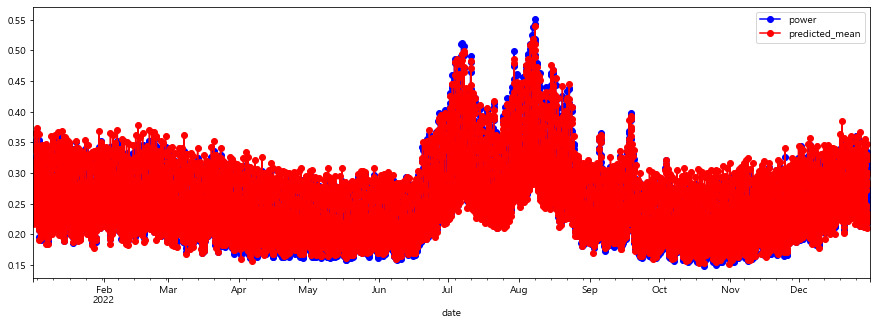

In [280]:
# ARIMA 모델 예측값 시각화

fig, ax = plt.subplots(figsize=(15,5))
#graph = sns.lineplot(x='date', y='power', data = train)

test.plot(ax=ax, color='blue', marker="o", legend=True)
pred1.plot(ax=ax, color='red', marker="o", legend=True)

In [281]:
# ARIMA 모델 요약

print(model_arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  power   No. Observations:                26277
Model:                 ARIMA(3, 0, 3)   Log Likelihood               74527.157
Date:                Fri, 10 Nov 2023   AIC                        -149038.314
Time:                        13:05:28   BIC                        -148972.902
Sample:                             0   HQIC                       -149017.193
                              - 26277                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2527      0.001    254.279      0.000       0.251       0.255
ar.L1          0.7367      0.071     10.342      0.000       0.597       0.876
ar.L2          0.4556      0.093      4.923      0.0

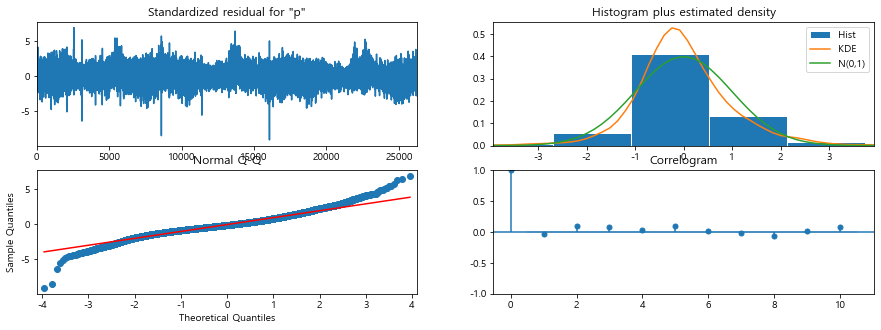

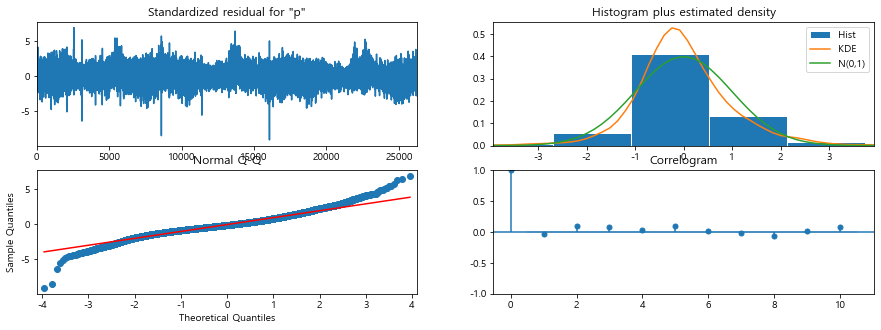

In [282]:
model_arima_fit.plot_diagnostics(figsize=(15,5))

In [283]:
#1년치 미래 예측
future_index=pd.date_range(start='2023-01-01',end='2024-01-01',freq='H')
future_forecast=model_arima_fit.predict(start=8761,end=8761+len(future_index)-1,typ='levels')

#데이터프레임 
low_forecast_df=pd.DataFrame({'date':future_index, 'power':future_forecast})
low_forecast_df.reset_index(drop=True, inplace=True)
low_forecast_df

,date,power
0,2023-01-01 00:00:00,0.255814
1,2023-01-01 01:00:00,0.229390
2,2023-01-01 02:00:00,0.207225
3,2023-01-01 03:00:00,0.222121
4,2023-01-01 04:00:00,0.235487
...,...,...
8756,2023-12-31 20:00:00,0.339153
8757,2023-12-31 21:00:00,0.317978
8758,2023-12-31 22:00:00,0.230473
8759,2023-12-31 23:00:00,0.241779


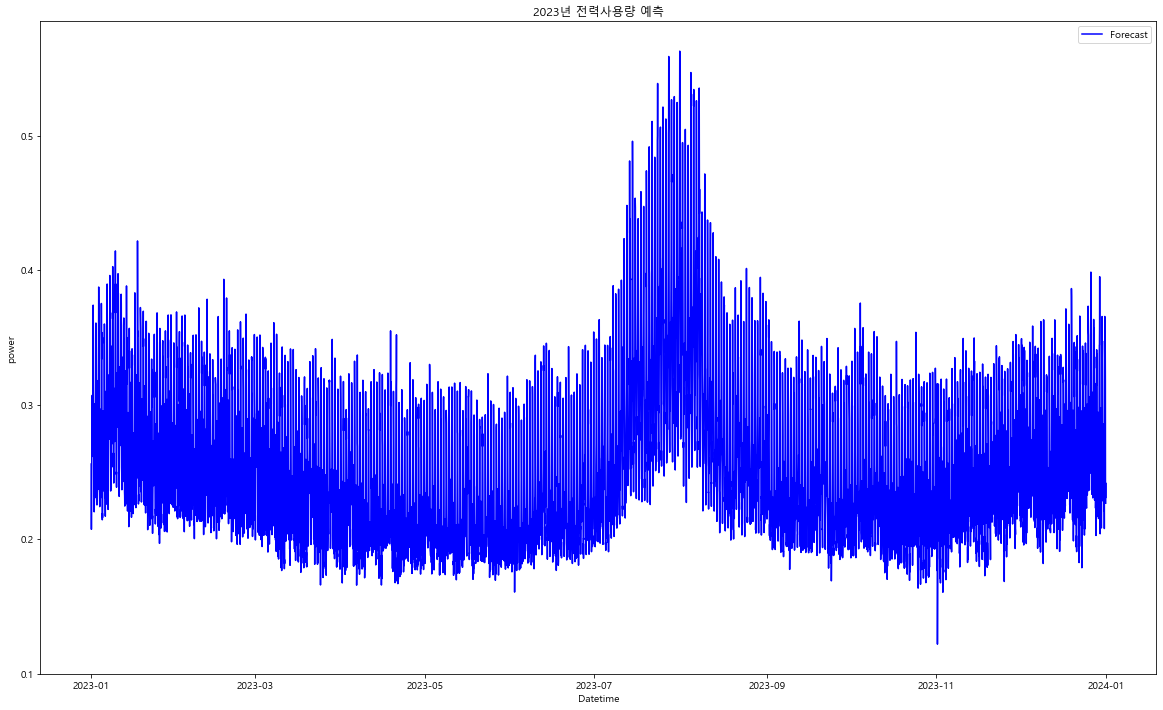

In [284]:
# 그래프 그리기
plt.figure(figsize=(20, 12))
plt.plot(low_forecast_df['date'], low_forecast_df['power'], label='Forecast', color='blue')
plt.legend()
plt.xlabel('Datetime')
plt.ylabel('power')
plt.title('2023년 전력사용량 예측')
plt.show()

## 3.3 TOU ARIMA 

In [285]:
# ARIMA용 학습셋, 테스트셋 생성

train= tou_ts.loc['2020-01-01':'2021-12-31']
test= tou_ts.loc['2022-01-01':'2022-12-31']

# 학습셋과 검증셋이 잘 나뉘었는지 확인
print('train data 개수: ', len(train))
print('test data 개수: ', len(test))

train data 개수:  17542
test data 개수:  8687


In [286]:
# ARIMA 예측값 출력

# p,d,q 파라미터값 설정
p, d, q = 3, 0, 3

model_arima = ARIMA(tou_ts, order=(p,d,q)) 
model_arima_fit = model_arima.fit()

# 예측값 출력

#pred1=model_arima_fit.predict(start=8759,end=8759+len(test)-1,typ='levels')

pred1 = model_arima_fit.predict(start = '2022-01-01', end ='2022-12-31', typ = 'level')
pred = pd.Series(pred1, index=test.index)

print(np.round_(pred,2))

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



date
2022-01-01 01:00:00    0.99
2022-01-01 02:00:00    0.73
2022-01-01 03:00:00    0.68
2022-01-01 04:00:00    0.59
2022-01-01 05:00:00    0.64
                       ... 
2022-12-31 19:00:00     NaN
2022-12-31 20:00:00     NaN
2022-12-31 21:00:00     NaN
2022-12-31 22:00:00     NaN
2022-12-31 23:00:00     NaN
Name: predicted_mean, Length: 8687, dtype: float64


<AxesSubplot:xlabel='date'>

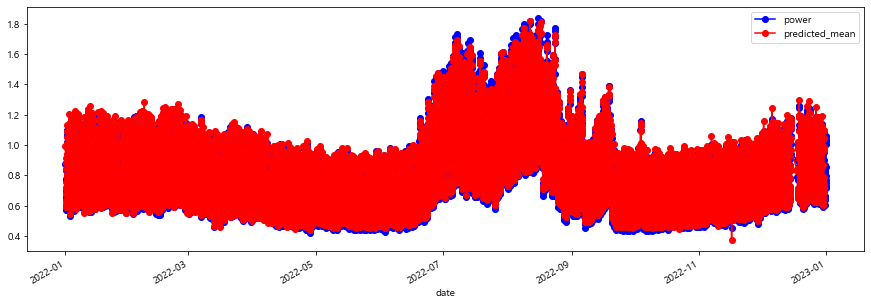

In [287]:
# ARIMA 모델 예측값 시각화

fig, ax = plt.subplots(figsize=(15,5))
#graph = sns.lineplot(x='Datetime', y='power', data = train)

test.plot(ax=ax, color='blue', marker="o", legend=True)
pred.plot(ax=ax, color='red', marker="o", legend=True)

In [288]:
# ARIMA 모델 요약

print(model_arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  power   No. Observations:                26229
Model:                 ARIMA(3, 0, 3)   Log Likelihood               40552.880
Date:                Fri, 10 Nov 2023   AIC                         -81089.760
Time:                        13:06:34   BIC                         -81024.363
Sample:                             0   HQIC                        -81068.642
                              - 26229                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7489      0.012     62.521      0.000       0.725       0.772
ar.L1          2.6718      0.007    410.485      0.000       2.659       2.685
ar.L2         -2.4918      0.012   -204.050      0.0

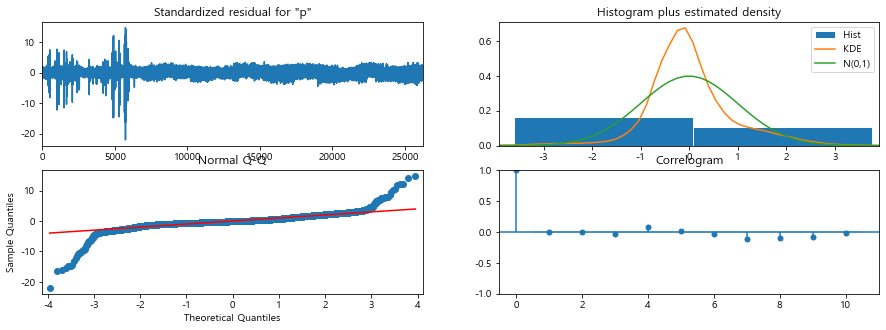

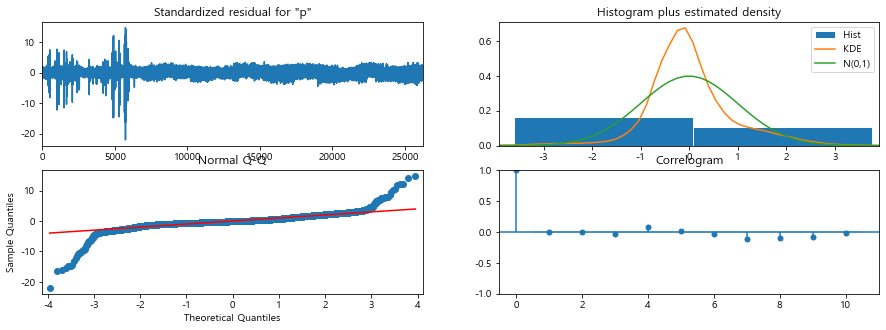

In [289]:
model_arima_fit.plot_diagnostics(figsize=(15,5))

In [290]:
#1년치 미래 예측
future_index=pd.date_range(start='2023-01-01',end='2024-01-01',freq='H')
future_forecast=model_arima_fit.predict(start=8761,end=8761+len(future_index)-1,typ='levels')

#데이터프레임 
tou_forecast_df=pd.DataFrame({'date':future_index, 'power':future_forecast})
tou_forecast_df.reset_index(drop=True, inplace=True)
tou_forecast_df

,date,power
0,2023-01-01 00:00:00,0.653557
1,2023-01-01 01:00:00,0.614703
2,2023-01-01 02:00:00,0.586603
3,2023-01-01 03:00:00,0.602224
4,2023-01-01 04:00:00,0.592262
...,...,...
8756,2023-12-31 20:00:00,1.072560
8757,2023-12-31 21:00:00,1.019023
8758,2023-12-31 22:00:00,0.873875
8759,2023-12-31 23:00:00,0.734926


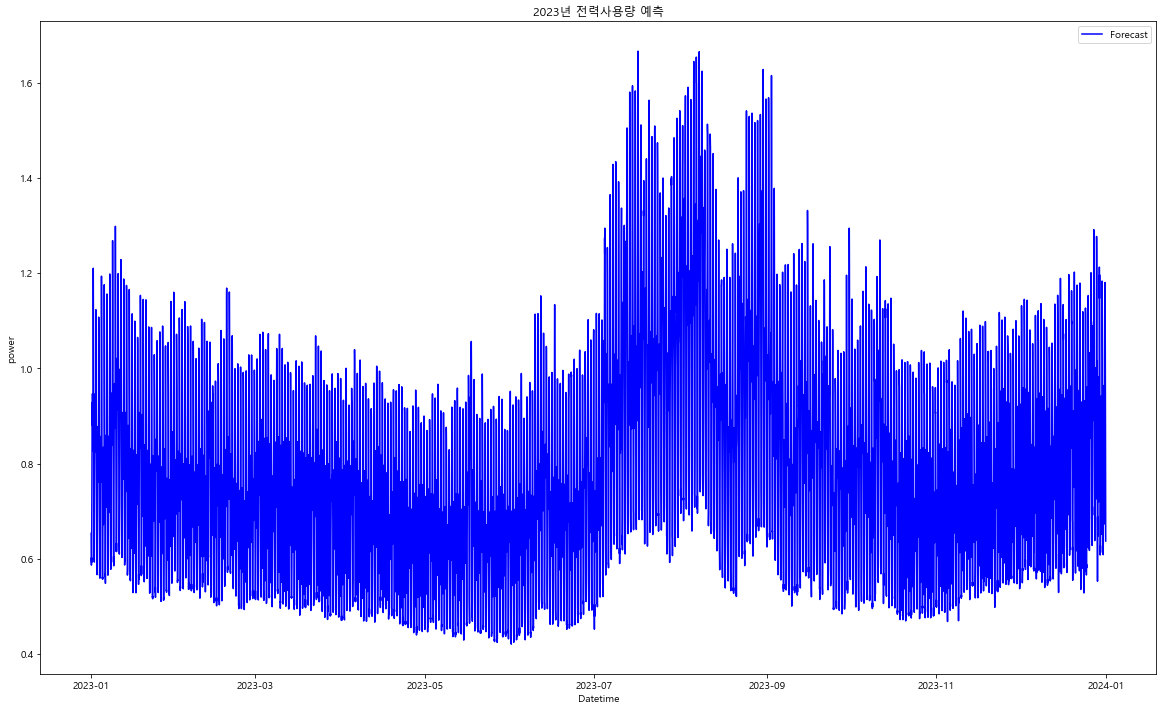

In [291]:
# 그래프 그리기
plt.figure(figsize=(20, 12))
plt.plot(tou_forecast_df['date'], tou_forecast_df['power'], label='Forecast', color='blue')
plt.legend()
plt.xlabel('Datetime')
plt.ylabel('power')
plt.title('2023년 전력사용량 예측')
plt.show()

# 4. 예측 값 시각화

In [299]:
high_forecast_ts = high_forecast_df.set_index('date')
low_forecast_ts = low_forecast_df.set_index('date')
tou_forecast_ts = tou_forecast_df.set_index('date')

Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.


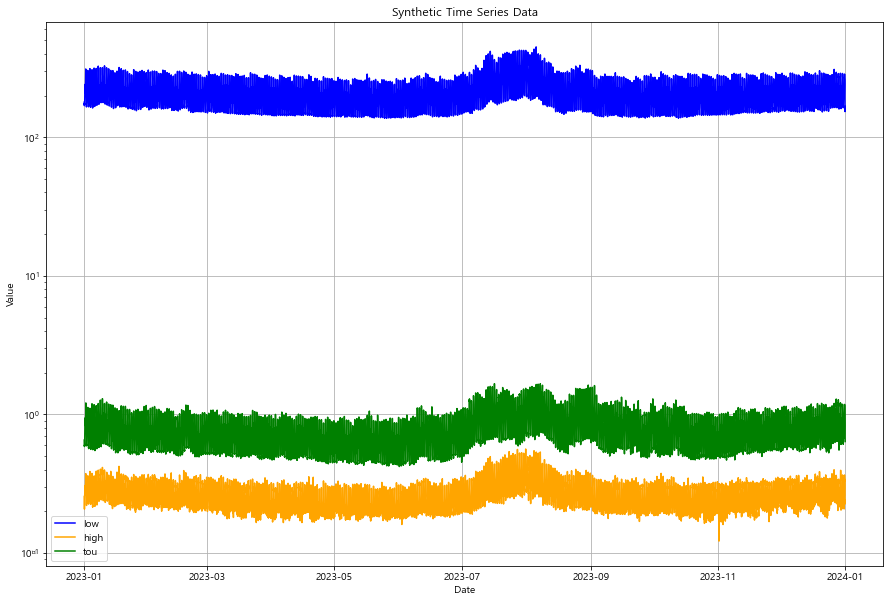

In [300]:
# 시계열 데이터를 화면에 출력한다.
plt.figure(figsize=(15, 10))
plt.plot(high_forecast_ts, color='blue', label = 'low')
plt.plot(low_forecast_ts, color='orange', label = 'high')
plt.plot(tou_forecast_ts, color='green', label = 'tou')
plt.xlabel('Date')
plt.ylabel('Value')
plt.yscale('log')
plt.title('Synthetic Time Series Data')
plt.legend()
plt.grid(True)